# Load the libraries

In [1]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
source("pca_cell_type_plot.R")


Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed.V4";

# Load the necessary input

In [3]:
## in this iteration, we only have data from UCSF SLE and Broad ImmVar

## Load the processed expression data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [5]:
cm_expr <- fread("v4.expr/v4.full.CD14 Mono.expr.txt");
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {strsplit(x,"_")[[1]][[1]]})
expr_gene_names <- cm_expr$V1;
cm_expr <- as.matrix(cm_expr[,-1]);

th_expr <- as.matrix(fread("v4.expr/v4.full.CD4+ T.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(th_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

tc_expr <- as.matrix(fread("v4.expr/v4.full.CD8+ T.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

ncm_expr <- as.matrix(fread("v4.expr/v4.full.CD16 Mono.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

b_expr <- as.matrix(fread("v4.expr/v4.full.B.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

nk_expr <- as.matrix(fread("v4.expr/v4.full.NK.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

dc_expr <- as.matrix(fread("v4.expr/v4.full.cDC.expr.txt")[,-1]);
colnames(dc_expr) <- sapply(colnames(dc_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

pbmc_expr <- as.matrix(fread("v4.expr/v4.full.PBMC.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(dc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(dc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
dc_expr <- dc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];

sle_indices <- setdiff((1:ncol(pbmc_expr)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

healthy_indices <- grep("IGTB",colnames(pbmc_expr))
healthy_colnames <- colnames(pbmc_expr)[healthy_indices]

cm_healthy_expr <- cm_expr[,healthy_indices]
th_healthy_expr <- th_expr[,healthy_indices]
tc_healthy_expr <- tc_expr[,healthy_indices]
ncm_healthy_expr <- ncm_expr[,healthy_indices]
b_healthy_expr <- b_expr[,healthy_indices]
nk_healthy_expr <- nk_expr[,healthy_indices]
dc_healthy_expr <- dc_expr[,healthy_indices]
pbmc_healthy_expr <- pbmc_expr[,healthy_indices]

Warning message in fread("v4.expr/v4.full.CD14 Mono.expr.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD4+ T.expr.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD8+ T.expr.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() a

In [6]:
standardize <- function(x) {(x-mean(x))/sd(x)}

pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0


In [7]:
pbmc_expr_prcomp <- prcomp(pbmc_expr)

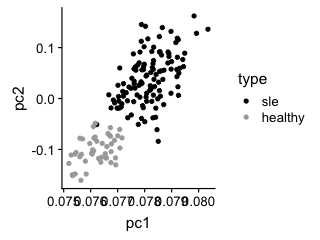

In [8]:
df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[1:ncol(pbmc_sle_expr),1], pc2=pbmc_expr_prcomp$rotation[1:ncol(pbmc_sle_expr),2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[(ncol(pbmc_sle_expr)+1):ncol(pbmc_expr),1], pc2=pbmc_expr_prcomp$rotation[(ncol(pbmc_sle_expr)+1):ncol(pbmc_expr),2], type="healthy"))

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray"))

## Load the raw counts from ```/ye/yelabstore2/10x.lupus/disease/demux.v2```

In [12]:
## either load only the original samples

# cm_counts <- fread("v2.deseq/norep.noadjrace.CD14+.Monocytes.counts.txt");
# colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# th_counts <- fread("v2.deseq/norep.noadjrace.CD4.T.cells.counts.txt");
# colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# tc_counts <- fread("v2.deseq/norep.noadjrace.CD8.T.cells.counts.txt");
# colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# ncm_counts <- fread("v2.deseq/norep.noadjrace.FCGR3A+.Monocytes.counts.txt");
# colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# b_counts <- fread("v2.deseq/norep.noadjrace.B.cells.counts.txt");
# colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# nk_counts <- fread("v2.deseq/norep.noadjrace.NK.cells.counts.txt");
# colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# dc_counts <- fread("v2.deseq/norep.noadjrace.Dendritic.cells.counts.txt");
# colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# pbmc_counts <- fread("v2.deseq/norep.noadjrace.PBMC.counts.txt");
# colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


## or new with immvar as separate

cm_counts <- fread("v4.deseq/v4.CD14 Mono.counts.txt");
colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

th_counts <- fread("v4.deseq/v4.CD4+ T.counts.txt");
colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

tc_counts <- fread("v4.deseq/v4.CD8+ T.counts.txt");
colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

ncm_counts <- fread("v4.deseq/v4.CD16 Mono.counts.txt");
colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

b_counts <- fread("v4.deseq/v4.B.counts.txt");
colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

nk_counts <- fread("v4.deseq/v4.NK.counts.txt");
colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

dc_counts <- fread("v4.deseq/v4.cDC.counts.txt");
colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

pbmc_counts <- fread("v4.deseq/v4.PBMC.counts.txt");
colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


counts_gene_names <- cm_counts$gene;
cm_counts <- as.matrix(cm_counts[,-1]);
pbmc_counts <- as.matrix(pbmc_counts[,-1]);
th_counts <- as.matrix(th_counts[,-1]);
tc_counts <- as.matrix(tc_counts[,-1]);
b_counts <- as.matrix(b_counts[,-1]);
ncm_counts <- as.matrix(ncm_counts[,-1]);
nk_counts <- as.matrix(nk_counts[,-1]);
dc_counts <- as.matrix(dc_counts[,-1]);

all_counts_samples <- na.omit(match(colnames(pbmc_expr), colnames(pbmc_counts)))

cm_counts <- cm_counts[,all_counts_samples]
pbmc_counts <- pbmc_counts[,all_counts_samples]
th_counts <- th_counts[,all_counts_samples]
tc_counts <- tc_counts[,all_counts_samples]
b_counts <- b_counts[,all_counts_samples]
ncm_counts <- ncm_counts[,all_counts_samples]
nk_counts <- nk_counts[,all_counts_samples]
dc_counts <- dc_counts[,all_counts_samples]

sle_counts_samples <- na.omit(match(colnames(pbmc_sle_expr), colnames(pbmc_counts)))

cm_sle_counts <- cm_counts[,sle_counts_samples]
th_sle_counts <- th_counts[,sle_counts_samples]
tc_sle_counts <- tc_counts[,sle_counts_samples]
ncm_sle_counts <- ncm_counts[,sle_counts_samples]
b_sle_counts <- b_counts[,sle_counts_samples]
nk_sle_counts <- nk_counts[,sle_counts_samples]
dc_sle_counts <- dc_counts[,sle_counts_samples]
pbmc_sle_counts <- pbmc_counts[,sle_counts_samples]


healthy_counts_samples <- na.omit(match(colnames(pbmc_healthy_expr), colnames(pbmc_counts)))

cm_healthy_counts <- cm_counts[,healthy_counts_samples]
th_healthy_counts <- th_counts[,healthy_counts_samples]
tc_healthy_counts <- tc_counts[,healthy_counts_samples]
ncm_healthy_counts <- ncm_counts[,healthy_counts_samples]
b_healthy_counts <- b_counts[,healthy_counts_samples]
nk_healthy_counts <- nk_counts[,healthy_counts_samples]
dc_healthy_counts <- dc_counts[,healthy_counts_samples]
pbmc_healthy_counts <- pbmc_counts[,healthy_counts_samples]



Warning message in fread("v4.deseq/v4.CD14 Mono.counts.txt"):
“Detected 141 column names but the data has 142 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.deseq/v4.CD4+ T.counts.txt"):
“Detected 141 column names but the data has 142 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.deseq/v4.CD8+ T.counts.txt"):
“Detected 141 column names but the data has 142 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwa

## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [14]:
pbmc_covars <- as.data.frame(fread("v4.expr/v4.full.PBMC.covariates.txt"))[,-1];
cm_covars <- as.data.frame(fread("v4.expr/v4.full.CD14 Mono.covariates.txt"))[,-1];
th_covars <- as.data.frame(fread("v4.expr/v4.full.CD4+ T.covariates.txt"))[,-1];
tc_covars <- as.data.frame(fread("v4.expr/v4.full.CD8+ T.covariates.txt"))[,-1];
ncm_covars <- as.data.frame(fread("v4.expr/v4.full.CD16 Mono.covariates.txt"))[,-1];
b_covars <- as.data.frame(fread("v4.expr/v4.full.B.covariates.txt"))[,-1];
dc_covars <- as.data.frame(fread("v4.expr/v4.full.cDC.covariates.txt"))[,-1];

Warning message in fread("v4.expr/v4.full.PBMC.covariates.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD14 Mono.covariates.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD4+ T.covariates.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. 

## Load the differentially expression results

In [16]:
# match(c('IL6','CCR7','IFI44L','CD14'), pbmc_deseq$V1)

In [17]:
# length(which(pbmc_deseq$qval<0.05))

In [20]:
pbmc_deseq <- fread("v4.deseq/v4..PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v4.deseq/v4..CD4+ T.deseq.txt"))
tc_deseq <- as.data.frame(fread("v4.deseq/v4..CD8+ T.deseq.txt"))
cm_deseq <- as.data.frame(fread("v4.deseq/v4..CD14 Mono.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v4.deseq/v4..CD16 Mono.deseq.txt"))
b_deseq <- as.data.frame(fread("v4.deseq/v4..B.deseq.txt"))
nk_deseq <- as.data.frame(fread("v4.deseq/v4..NK.deseq.txt"))
dc_deseq <- as.data.frame(fread("v4.deseq/v4..cDC.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v4.deseq/v4..PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v4.deseq/v4..CD4+ T.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v4.deseq/v4..CD8+ T.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v4.deseq/v4..CD14 Mono.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v4.deseq/v4..CD16 Mono.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v4.deseq/v4..B.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v4.deseq/v4..NK.deseq.sig.txt",header=F))$V1
dc_deseq_sig <- as.data.frame(fread("v4.deseq/v4..cDC.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, dc_deseq_sig));

Warning message in fread("v4.deseq/v4..PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.deseq/v4..CD4+ T.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.deseq/v4..CD8+ T.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess

In [21]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.05))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.05))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.05))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.05))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.05))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.05))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.05))]
dc_deseq_sig_genes <- dc_deseq$V1[intersect(which(abs(dc_deseq$log2FoldChange)>1),which(dc_deseq$qval < 0.05))]

# union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, dc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
# union_deseq_sig_genes <- intersect(union_deseq_sig_genes, pbmc_deseq$V1[which(pbmc_deseq$baseMean>20)])
# length(union_deseq_sig_genes)
# length(pbmc_deseq_sig_genes)
# length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))
# union_deseq_sig_genes <- union_deseq_sig_genes[-grep("IGLL5",union_deseq_sig_genes)]

In [22]:
standardize <- function(x) {(x-mean(x))/sd(x)}

all_expr_standardize <- data.frame(pbmc=t(apply(pbmc_expr,1,standardize)),
                      cm=t(apply(cm_expr,1,standardize)),
                      ncm=t(apply(ncm_expr,1,standardize)),
                      dc=t(apply(dc_expr,1,standardize)),
                      th=t(apply(th_expr,1,standardize)),
                      tc=t(apply(tc_expr,1,standardize)),
                       nk=t(apply(nk_expr,1,standardize)),
                      b=t(apply(b_expr,1,standardize)),
                        dc=t(apply(dc_expr,1,standardize))
                      )


all_expr <- data.frame(pbmc=pbmc_expr,
                      cm=cm_expr,
                      ncm=ncm_expr,
                      dc=dc_expr,
                      th=th_expr,
                      tc=tc_expr,
                       nk=nk_expr,
                      b=b_expr
                      )

all_expr_sle <- data.frame(pbmc=pbmc_sle_expr,
                      cm=cm_sle_expr,
                      ncm=ncm_sle_expr,
                      dc=dc_sle_expr,
                      th=th_sle_expr,
                      tc=tc_sle_expr,
                       nk=nk_sle_expr,
                      b=b_sle_expr
                      )
rownames(all_expr_sle) <- rownames(all_expr)


In [23]:
set.seed(1)
kmeans_rst <- kmeans(all_expr[match(pbmc_deseq_sig_genes,expr_gene_names),], 7)

cell_types <- c("PBMC","cM","ncM", "DC","Th","Tc","NK","B")
ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
                           disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),rep("ctrl",ncol(cm_healthy_expr))),length(cell_types))))
rownames(ct_annotation) <- colnames(all_expr);

kmeans_annotation <- data.frame(cluster=factor(kmeans_rst$cluster,levels=c("1","2","6","11","13","15","12","7","8","3","9","10","14","4","5")))
rownames(kmeans_annotation) <- pbmc_deseq_sig_genes;

all_expr_sig <- all_expr[match(pbmc_deseq_sig_genes,expr_gene_names),]
all_expr_sig_ordered <- all_expr[match(pbmc_deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]
kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]

all_expr_sle_sig <- all_expr_sle[match(pbmc_deseq_sig_genes,expr_gene_names),]
all_expr_sle_sig_ordered <- all_expr_sle[match(pbmc_deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]
##kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]


##bct_annotation <- list(ct_annotation=ct_annotation)

## Load the joined table and preprocess the expression and counts data

In [25]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
joined_pivot <- as.data.frame(joined_pivot);
joined_pivot$batch_cov <- as.factor(joined_pivot$batch_cov)

joined_pivot_filtered <- joined_pivot[match(c(colnames(pbmc_sle_expr),colnames(pbmc_healthy_expr)),joined_pivot$ind_cov),]
joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_pivot$ind_cov),]
joined_pivot_healthy <- joined_pivot[match(colnames(pbmc_healthy_expr), joined_pivot$ind_cov),]

## get the cell type proportions

In [26]:
cm_prop = joined_pivot_filtered$"CD14 Mo";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot_filtered$"CD4+ T";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot_filtered$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot_filtered$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot_filtered$"CD16 Mo";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot_filtered$"CD8+ T";#/joined_pivot_filtered$pbmc;
dc_prop = joined_pivot_filtered$"cDC";#/joined_pivot_filtered$pbmc;

## set the NAs to 0
b_prop[which(is.na(b_prop))] <- 0;
dc_prop[which(is.na(dc_prop))] <- 0;

cm_sle_prop = cm_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
th_sle_prop = th_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
b_sle_prop = b_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
nk_sle_prop = nk_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
ncm_sle_prop = ncm_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
tc_sle_prop = tc_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
dc_sle_prop = dc_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]

cm_healthy_prop = cm_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
th_healthy_prop = th_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
b_healthy_prop = b_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
nk_healthy_prop = nk_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
ncm_healthy_prop = ncm_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
tc_healthy_prop = tc_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
dc_healthy_prop = dc_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]

In [29]:
cor(colMeans(cm_expr), cm_prop)
cor(colMeans(th_expr), th_prop)
cor(colMeans(tc_expr), tc_prop)
cor(colMeans(nk_expr), nk_prop)
cor(colMeans(ncm_expr), ncm_prop)

[1] -0.2194556

[1] 0.08211384

[1] -0.1464221

[1] -0.1311148

[1] -0.3373309

In [17]:
dim(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))))

[1] 166 166

In [18]:
dim(cor(cbind(pbmc_expr_std)))

[1] 166 166

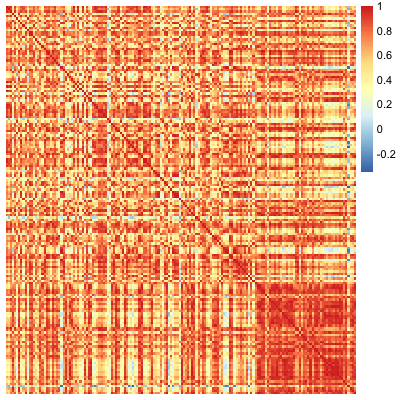

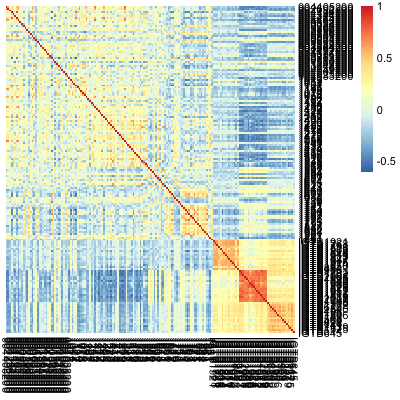

In [19]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F)

# Let's do some batch adjustments

## first, let's cell type proportion

In [20]:
cm_prop_mean = lm(cm_prop~1)$fitted;
th_prop_mean = lm(th_prop~1)$fitted;
b_prop_mean = lm(b_prop~1)$fitted;
nk_prop_mean = lm(nk_prop~1)$fitted;
ncm_prop_mean = lm(ncm_prop~1)$fitted;
tc_prop_mean = lm(tc_prop~1)$fitted;
dc_prop_mean = lm(dc_prop~1)$fitted;

cm_prop = lm(cm_prop~joined_pivot_filtered$batch_cov)$residual+cm_prop_mean;
th_prop = lm(th_prop~joined_pivot_filtered$batch_cov)$residual+th_prop_mean;
b_prop = lm(b_prop~joined_pivot_filtered$batch_cov)$residual+b_prop_mean;
nk_prop = lm(nk_prop~joined_pivot_filtered$batch_cov)$residual+nk_prop_mean;
ncm_prop = lm(ncm_prop~joined_pivot_filtered$batch_cov)$residual+ncm_prop_mean;
tc_prop = lm(tc_prop~joined_pivot_filtered$batch_cov)$residual+tc_prop_mean;
dc_prop = lm(dc_prop~joined_pivot_filtered$batch_cov)$residual+dc_prop_mean;

cm_sle_prop_mean = lm(cm_sle_prop~1)$fitted;
th_sle_prop_mean = lm(th_sle_prop~1)$fitted;
b_sle_prop_mean = lm(b_sle_prop~1)$fitted;
ncm_sle_prop_mean = lm(ncm_sle_prop~1)$fitted;
nk_sle_prop_mean = lm(nk_sle_prop~1)$fitted;
tc_sle_prop_mean = lm(tc_sle_prop~1)$fitted;
dc_sle_prop_mean = lm(dc_sle_prop~1)$fitted;

cm_sle_prop = lm(cm_sle_prop~joined_pivot_sle$batch_cov)$residual+cm_sle_prop_mean;
th_sle_prop = lm(th_sle_prop~joined_pivot_sle$batch_cov)$residual+th_sle_prop_mean;
b_sle_prop = lm(b_sle_prop~joined_pivot_sle$batch_cov)$residual+b_sle_prop_mean;
nk_sle_prop = lm(nk_sle_prop~joined_pivot_sle$batch_cov)$residual+nk_sle_prop_mean;
ncm_sle_prop = lm(ncm_sle_prop~joined_pivot_sle$batch_cov)$residual+ncm_sle_prop_mean;
tc_sle_prop = lm(tc_sle_prop~joined_pivot_sle$batch_cov)$residual+tc_sle_prop_mean;
dc_sle_prop = lm(dc_sle_prop~joined_pivot_sle$batch_cov)$residual+dc_sle_prop_mean;

cm_healthy_prop_mean = lm(cm_healthy_prop~1)$fitted;
th_healthy_prop_mean = lm(th_healthy_prop~1)$fitted;
b_healthy_prop_mean = lm(b_healthy_prop~1)$fitted;
ncm_healthy_prop_mean = lm(ncm_healthy_prop~1)$fitted;
nk_healthy_prop_mean = lm(nk_healthy_prop~1)$fitted;
tc_healthy_prop_mean = lm(tc_healthy_prop~1)$fitted;
dc_healthy_prop_mean = lm(dc_healthy_prop~1)$fitted;

cm_healthy_prop = lm(cm_healthy_prop~joined_pivot_healthy$batch_cov)$residual+cm_healthy_prop_mean;
th_healthy_prop = lm(th_healthy_prop~joined_pivot_healthy$batch_cov)$residual+th_healthy_prop_mean;
b_healthy_prop = lm(b_healthy_prop~joined_pivot_healthy$batch_cov)$residual+b_healthy_prop_mean;
nk_healthy_prop = lm(nk_healthy_prop~joined_pivot_healthy$batch_cov)$residual+nk_healthy_prop_mean;
ncm_healthy_prop = lm(ncm_healthy_prop~joined_pivot_healthy$batch_cov)$residual+ncm_healthy_prop_mean;
tc_healthy_prop = lm(tc_healthy_prop~joined_pivot_healthy$batch_cov)$residual+tc_healthy_prop_mean;
dc_healthy_prop = lm(dc_healthy_prop~joined_pivot_healthy$batch_cov)$residual+dc_healthy_prop_mean;

## second, let's adjust cell type specific expression

In [50]:
pbmc_mean <- t(lm(t(pbmc_expr)~1)$fitted)
cm_mean <- t(lm(t(cm_expr)~1)$fitted)
th_mean <- t(lm(t(th_expr)~1)$fitted)
b_mean <- t(lm(t(b_expr)~1)$fitted)
nk_mean <- t(lm(t(nk_expr)~1)$fitted)
ncm_mean <- t(lm(t(ncm_expr)~1)$fitted)
tc_mean <- t(lm(t(tc_expr)~1)$fitted)
dc_mean <- t(lm(t(dc_expr)~1)$fitted)

pbmc_expr <- t(lm(t(pbmc_expr)~joined_pivot_filtered$batch_cov)$residuals)+pbmc_mean
cm_expr <- t(lm(t(cm_expr)~joined_pivot_filtered$batch_cov)$residuals)+cm_mean
th_expr <- t(lm(t(th_expr)~joined_pivot_filtered$batch_cov)$residuals)+th_mean
b_expr <- t(lm(t(b_expr)~joined_pivot_filtered$batch_cov)$residuals)+b_mean
nk_expr <- t(lm(t(nk_expr)~joined_pivot_filtered$batch_cov)$residuals)+nk_mean
ncm_expr <- t(lm(t(ncm_expr)~joined_pivot_filtered$batch_cov)$residuals)+ncm_mean
tc_expr <- t(lm(t(tc_expr)~joined_pivot_filtered$batch_cov)$residuals)+tc_mean
dc_expr <- t(lm(t(dc_expr)~joined_pivot_filtered$batch_cov)$residuals)+dc_mean

pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0


pbmc_sle_mean <- t(lm(t(pbmc_sle_expr)~1)$fitted)
cm_sle_mean <- t(lm(t(cm_sle_expr)~1)$fitted)
th_sle_mean <- t(lm(t(th_sle_expr)~1)$fitted)
b_sle_mean <- t(lm(t(b_sle_expr)~1)$fitted)
nk_sle_mean <- t(lm(t(nk_sle_expr)~1)$fitted)
ncm_sle_mean <- t(lm(t(ncm_sle_expr)~1)$fitted)
tc_sle_mean <- t(lm(t(tc_sle_expr)~1)$fitted)
dc_sle_mean <- t(lm(t(dc_sle_expr)~1)$fitted)

pbmc_sle_expr <- t(lm(t(pbmc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+pbmc_sle_mean
cm_sle_expr <- t(lm(t(cm_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+cm_sle_mean
th_sle_expr <- t(lm(t(th_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+th_sle_mean
b_sle_expr <- t(lm(t(b_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+b_sle_mean
nk_sle_expr <- t(lm(t(nk_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+nk_sle_mean
ncm_sle_expr <- t(lm(t(ncm_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+ncm_sle_mean
tc_sle_expr <- t(lm(t(tc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+tc_sle_mean
dc_sle_expr <- t(lm(t(dc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+dc_sle_mean


pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_std <- t(apply(cm_sle_expr,1,standardize))
cm_sle_expr_std[is.na(cm_sle_expr_std)] <- 0
th_sle_expr_std <- t(apply(th_sle_expr,1,standardize))
th_sle_expr_std[is.na(th_sle_expr_std)] <- 0
b_sle_expr_std <- t(apply(b_sle_expr,1,standardize))
b_sle_expr_std[is.na(b_sle_expr_std)] <- 0
nk_sle_expr_std <- t(apply(nk_sle_expr,1,standardize))
nk_sle_expr_std[is.na(nk_sle_expr_std)] <- 0
ncm_sle_expr_std <- t(apply(ncm_sle_expr,1,standardize))
ncm_sle_expr_std[is.na(ncm_sle_expr_std)] <- 0
tc_sle_expr_std <- t(apply(tc_sle_expr,1,standardize))
tc_sle_expr_std[is.na(tc_sle_expr_std)] <- 0
dc_sle_expr_std <- t(apply(dc_sle_expr,1,standardize))
dc_sle_expr_std[is.na(dc_sle_expr_std)] <- 0


pbmc_healthy_mean <- t(lm(t(pbmc_healthy_expr)~1)$fitted)
cm_healthy_mean <- t(lm(t(cm_healthy_expr)~1)$fitted)
th_healthy_mean <- t(lm(t(th_healthy_expr)~1)$fitted)
b_healthy_mean <- t(lm(t(b_healthy_expr)~1)$fitted)
nk_healthy_mean <- t(lm(t(nk_healthy_expr)~1)$fitted)
ncm_healthy_mean <- t(lm(t(ncm_healthy_expr)~1)$fitted)
tc_healthy_mean <- t(lm(t(tc_healthy_expr)~1)$fitted)
dc_healthy_mean <- t(lm(t(dc_healthy_expr)~1)$fitted)

pbmc_healthy_expr <- t(lm(t(pbmc_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+pbmc_healthy_mean
cm_healthy_expr <- t(lm(t(cm_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+cm_healthy_mean
th_healthy_expr <- t(lm(t(th_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+th_healthy_mean
b_healthy_expr <- t(lm(t(b_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+b_healthy_mean
nk_healthy_expr <- t(lm(t(nk_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+nk_healthy_mean
ncm_healthy_expr <- t(lm(t(ncm_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+ncm_healthy_mean
tc_healthy_expr <- t(lm(t(tc_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+tc_healthy_mean
dc_healthy_expr <- t(lm(t(dc_healthy_expr)~joined_pivot_healthy$batch_cov)$residuals)+dc_healthy_mean

pbmc_healthy_expr_std <- t(apply(pbmc_healthy_expr,1,standardize))
cm_healthy_expr_std <- t(apply(cm_healthy_expr,1,standardize))
cm_healthy_expr_std[is.na(cm_healthy_expr_std)] <- 0
th_healthy_expr_std <- t(apply(th_healthy_expr,1,standardize))
th_healthy_expr_std[is.na(th_healthy_expr_std)] <- 0
b_healthy_expr_std <- t(apply(b_healthy_expr,1,standardize))
b_healthy_expr_std[is.na(b_healthy_expr_std)] <- 0
nk_healthy_expr_std <- t(apply(nk_healthy_expr,1,standardize))
nk_healthy_expr_std[is.na(nk_healthy_expr_std)] <- 0
ncm_healthy_expr_std <- t(apply(ncm_healthy_expr,1,standardize))
ncm_healthy_expr_std[is.na(ncm_healthy_expr_std)] <- 0
tc_healthy_expr_std <- t(apply(tc_healthy_expr,1,standardize))
tc_healthy_expr_std[is.na(tc_healthy_expr_std)] <- 0
dc_healthy_expr_std <- t(apply(dc_healthy_expr,1,standardize))
dc_healthy_expr_std[is.na(dc_healthy_expr_std)] <- 0


## plot both

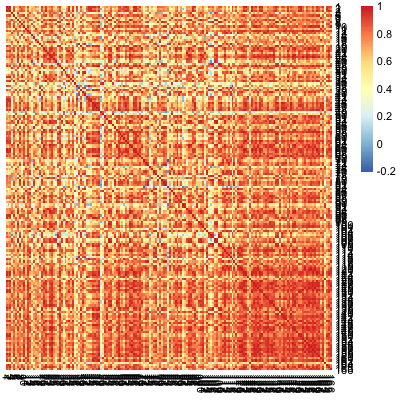

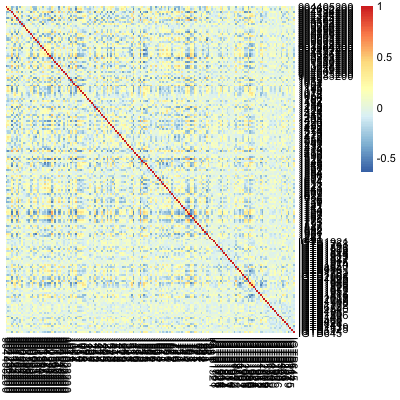

In [51]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F)

# Figure 2A - heatmap

pdf 
  2

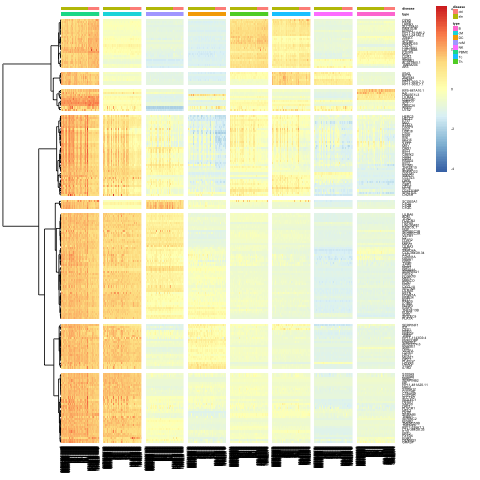

In [52]:
options(repr.plot.width = 6, repr.plot.height = 6)
pheatmap_out <- pheatmap(all_expr_sig,
         cluster_rows=T, cluster_cols=F, annotation_col = ct_annotation, #annotation_row = kmeans_annotation,
        gaps_col=seq(ncol(cm_expr),ncol(cm_expr)*length(cell_types),ncol(cm_expr)),cutree_rows=8, 
                         scale="row",fontsize=3,clustering_method="ward.D",clustering_distance_roww="manhattan")
options(repr.plot.width = 4, repr.plot.height = 4)

save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 150) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
 
save_pheatmap_png(pheatmap_out, file="heatmap.png")

## More principled way to cut the tree and label the specific signatures

In [53]:
cuttree_out <- cutree(pheatmap_out$tree_row, k = 8)
cuttree_out[which(cuttree_out==4)] <- "dc_specific";
cuttree_out[which(cuttree_out==8)] <- "tc_specific";
cuttree_out[which(cuttree_out==1)] <- "th_specific";
cuttree_out[which(cuttree_out==6)] <- "all_ifn";
cuttree_out[which(cuttree_out==3)] <- "myeloid_ifn";
cuttree_out[which(cuttree_out==2)] <- "ncM_ifn";
cuttree_out[which(cuttree_out==7)] <- "cM_DC_ifn";
cuttree_out[which(cuttree_out==5)] <- "cM_ifn";

cuttree_gene_names <- names(cuttree_out);
cuttree_out <- cbind(cuttree_gene_names,cuttree_out)
colnames(cuttree_out) <- c("gene","cluster")
write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

# Figure 2B - correlogram to show coexpressed genes

pdf 
  2

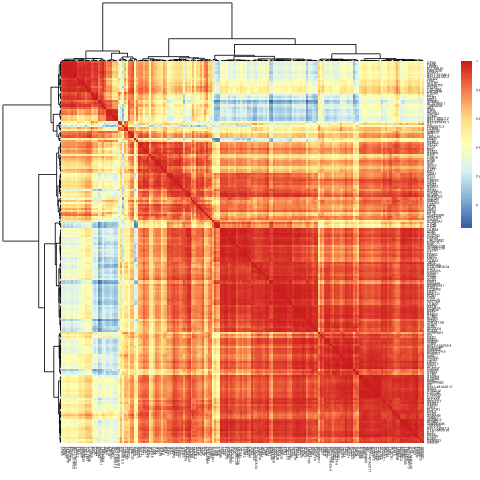

In [54]:
no_pbmc_cor <- cor(t(all_expr_sig[,-c(1,ncol(pbmc_expr))]))
options(repr.plot.width = 6, repr.plot.height = 6)
correlogram_out = pheatmap(no_pbmc_cor,
         cluster_rows=pheatmap_out$tree_row, cluster_cols=pheatmap_out$tree_row, #annotation_row = kmeans_annotation,
         fontsize=3)
options(repr.plot.width = 4, repr.plot.height = 4)

save_pheatmap_png(correlogram_out, file="corrrelogram.png")

# Figure 2C: Proportion of variance explained


First, we are going to estimate proportion of variance explained by cell type proportion

This will be a multiple regression

\begin{equation*}
e_i = -1 + b_1\times p_1 + b_2\times p_2 + ... + b_n\times p_n
\end{equation*}

Next, we are going to estimate proportion of variance explained by cell type specific expression

This will be a multiple regression


\begin{equation*}
e_i = -1 + b_1\times e_1 + b_2\times e_2 + ... + b_n\times e_n
\end{equation*}

calculate adjusted r_2 and also the cell type specific r2

Y_i = %mono*mono_i + %other*other_i + err
Or
Y_i = %mono*mono_i
log(Y_i) = log(%mono)+log(mono_i)+err


## Processing all - now, let's fit with -1 but we need to standardize the outcome

In [55]:
## including dc analysis
output_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_expr_std)) {
    model <- lm(pbmc_expr_std[i,]~cm_prop+th_prop+b_prop+nk_prop+ncm_prop+tc_prop+dc_prop-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_prop,th_prop,b_prop,nk_prop,ncm_prop,tc_prop,dc_prop), 2,var,na.rm=T)/var(pbmc_expr_std[i,])*100;
    output_prop_noint <- rbind(output_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_prop_noint) <- expr_gene_names;
colnames(output_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

output_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_expr_std)) {
    model <- lm(pbmc_expr_std[i,]~cm_expr_std[i,]+th_expr_std[i,]+b_expr_std[i,]+nk_expr_std[i,]+ncm_expr_std[i,]+tc_expr_std[i,]+dc_expr_std[i,]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_expr_std[i,],th_expr_std[i,],b_expr_std[i,],nk_expr_std[i,],ncm_expr_std[i,],tc_expr_std[i,],dc_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_expr_std[i,])*100;
    
    output_expr_noint <- rbind(output_expr_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_expr_noint) <- expr_gene_names;
colnames(output_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

## Processing SLE

### All of SLE

## flip how things are fit
## difference in likelihoods between model with T cells vs model without T cells

In [56]:
## including dc analysis
output_sle_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,]~cm_sle_prop+th_sle_prop+b_sle_prop+nk_sle_prop+ncm_sle_prop+tc_sle_prop+dc_sle_prop-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_prop,th_sle_prop,b_sle_prop,nk_sle_prop,ncm_sle_prop,tc_sle_prop,dc_sle_prop), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,])*100;
    output_sle_prop_noint <- rbind(output_sle_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_prop_noint) <- expr_gene_names;
colnames(output_sle_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

output_sle_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,]~cm_sle_expr_std[i,]+th_sle_expr_std[i,]+b_sle_expr_std[i,]+nk_sle_expr_std[i,]+ncm_sle_expr_std[i,]+tc_sle_expr_std[i,]+dc_sle_expr_std[i,]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_expr_std[i,],th_sle_expr_std[i,],b_sle_expr_std[i,],nk_sle_expr_std[i,],ncm_sle_expr_std[i,],tc_sle_expr_std[i,],dc_sle_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,])*100;
    
    output_sle_expr_noint <- rbind(output_sle_expr_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_expr_noint) <- expr_gene_names;
colnames(output_sle_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

[1] 0.5210968

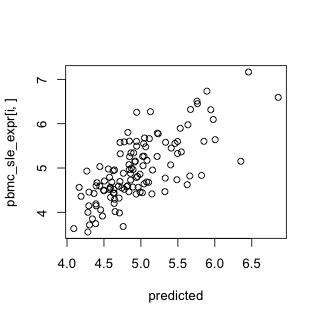

[1] 0.77651

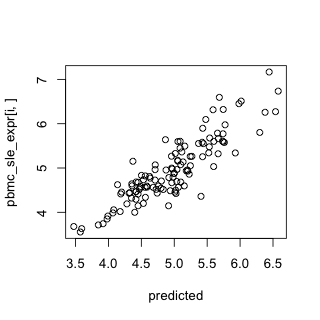

[1] 0.9458558

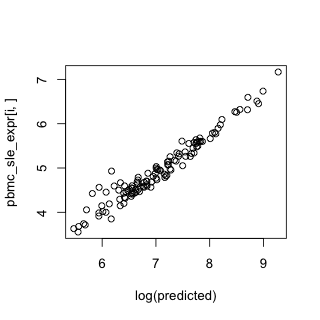

In [57]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=2
i=grep("^IL6$",expr_gene_names)[1]

model <- lm(pbmc_sle_expr[i,]~cm_sle_prop+th_sle_prop+b_sle_prop+nk_sle_prop+ncm_sle_prop+tc_sle_prop-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr[i,])
cor(predicted, pbmc_sle_expr[i,])^2

model <- lm(pbmc_sle_expr[i,]~th_sle_expr[i,]+cm_sle_expr[i,]+b_sle_expr[i,]+nk_sle_expr[i,]+ncm_sle_expr[i,]+tc_sle_expr[i,]-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr[i,])
cor(predicted, pbmc_sle_expr[i,])^2

predicted <- exp(th_sle_expr[i,])*th_sle_prop+exp(cm_sle_expr[i,])*cm_sle_prop+exp(b_sle_expr[i,])*b_sle_prop+
            exp(nk_sle_expr[i,])*nk_sle_prop+exp(ncm_sle_expr[i,])*ncm_sle_prop+exp(tc_sle_expr[i,])*tc_sle_prop
plot(log(predicted), pbmc_sle_expr[i,])
cor(log(predicted), pbmc_sle_expr[i,])^2


[1] 0.88066

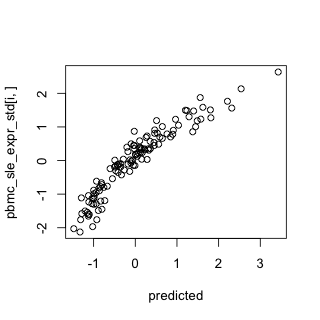

[1] 0.53173

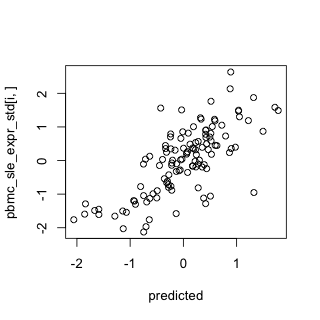

[1] 0.9499138

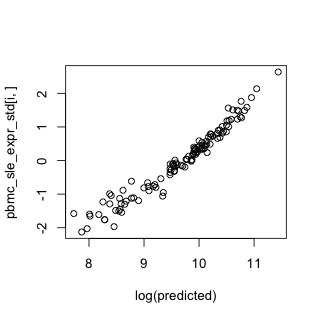

In [58]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=2
i=grep("^CD22$",expr_gene_names)[1]

model <- lm(pbmc_sle_expr_std[i,]~cm_sle_prop+th_sle_prop+b_sle_prop+nk_sle_prop+ncm_sle_prop+tc_sle_prop-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr_std[i,])
cor(predicted, pbmc_sle_expr_std[i,])^2

model <- lm(pbmc_sle_expr_std[i,]~cm_sle_expr_std[i,]+th_sle_expr_std[i,]+b_sle_expr_std[i,]+nk_sle_expr_std[i,]+ncm_sle_expr_std[i,]
            +tc_sle_expr_std[i,]-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr_std[i,])
cor(predicted, pbmc_sle_expr_std[i,])^2

predicted <- exp(th_sle_expr[i,])*th_sle_prop+exp(cm_sle_expr[i,])*cm_sle_prop+exp(b_sle_expr[i,])*b_sle_prop+
            exp(nk_sle_expr[i,])*nk_sle_prop+exp(ncm_sle_expr[i,])*ncm_sle_prop+exp(tc_sle_expr[i,])*tc_sle_prop
plot(log(predicted), pbmc_sle_expr_std[i,])
cor(log(predicted), pbmc_sle_expr_std[i,])^2


### Downsampled SLE to 46 samples

In [59]:
## including dc analysis
N <- 46;
samples <- sample(1:length(cm_sle_prop), N)

output_sle_down_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,samples]~cm_sle_prop[samples]+th_sle_prop[samples]+b_sle_prop[samples]+nk_sle_prop[samples]+ncm_sle_prop[samples]+tc_sle_prop[samples]+dc_sle_prop[samples]-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_prop[samples],th_sle_prop[samples],b_sle_prop[samples],nk_sle_prop[samples],ncm_sle_prop[samples],tc_sle_prop[samples],dc_sle_prop[samples]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,samples])*100;
    output_sle_down_prop_noint <- rbind(output_sle_down_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_down_prop_noint) <- expr_gene_names;
colnames(output_sle_down_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

output_sle_down_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,samples]~cm_sle_expr_std[i,samples]+th_sle_expr_std[i,samples]+b_sle_expr_std[i,samples]+nk_sle_expr_std[i,samples]+ncm_sle_expr_std[i,samples]+tc_sle_expr_std[i,samples]+dc_sle_expr_std[i,samples]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_expr_std[i,samples],th_sle_expr_std[i,samples],b_sle_expr_std[i,samples],nk_sle_expr_std[i,samples],ncm_sle_expr_std[i,samples],tc_sle_expr_std[i,samples],dc_sle_expr_std[i,samples]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,samples])*100;
    
    output_sle_down_expr_noint <- rbind(output_sle_down_expr_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_down_expr_noint) <- expr_gene_names;
colnames(output_sle_down_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

## Processing healthy

In [60]:
## including dc analysis
output_healthy_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_healthy_expr_std)) {
    model <- lm(pbmc_healthy_expr_std[i,]~cm_healthy_prop+th_healthy_prop+b_healthy_prop+nk_healthy_prop+ncm_healthy_prop+tc_healthy_prop+dc_healthy_prop-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_healthy_prop,th_healthy_prop,b_healthy_prop,nk_healthy_prop,ncm_healthy_prop,tc_healthy_prop,dc_healthy_prop), 2,var,na.rm=T)/var(pbmc_healthy_expr_std[i,])*100;
    output_healthy_prop_noint <- rbind(output_healthy_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_healthy_prop_noint) <- expr_gene_names;
colnames(output_healthy_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

output_healthy_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_healthy_expr_std)) {
    model <- lm(pbmc_healthy_expr_std[i,]~cm_healthy_expr_std[i,]+th_healthy_expr_std[i,]+
                b_healthy_expr_std[i,]+nk_healthy_expr_std[i,]+ncm_healthy_expr_std[i,]+tc_healthy_expr_std[i,]+dc_healthy_expr_std[i,]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_healthy_expr_std[i,],th_healthy_expr_std[i,],b_healthy_expr_std[i,],nk_healthy_expr_std[i,],ncm_healthy_expr_std[i,],tc_healthy_expr_std[i,],dc_healthy_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_healthy_expr_std[i,])*100;
    
    output_healthy_expr_noint <- rbind(output_healthy_expr_noint, 
                               c(r2,
                               sum(r2,na.rm=T),
                               summary(model)$adj.r.squared*100))
}

rownames(output_healthy_expr_noint) <- expr_gene_names;
colnames(output_healthy_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

## Summarize and plotting results

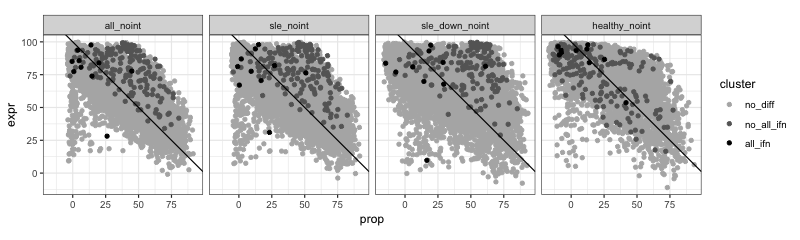

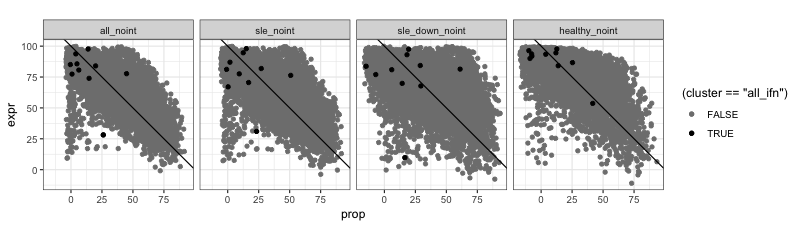

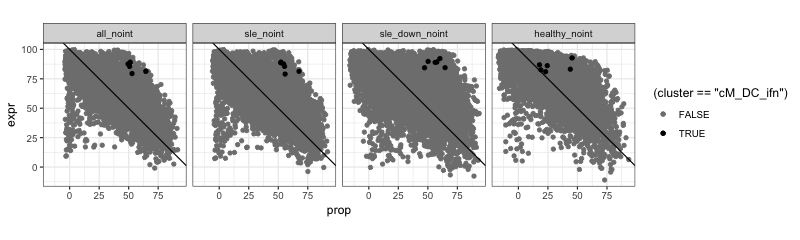

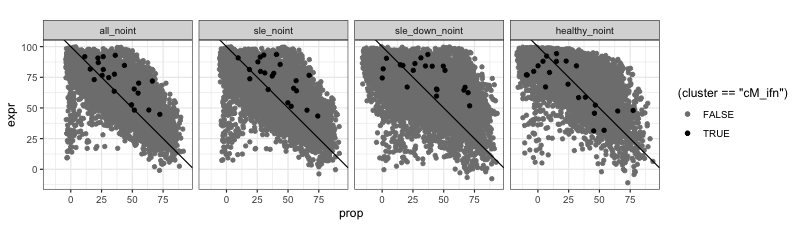

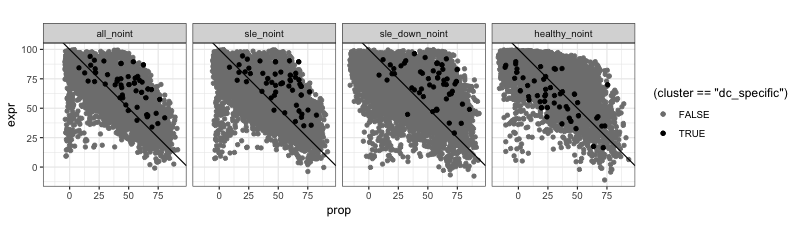

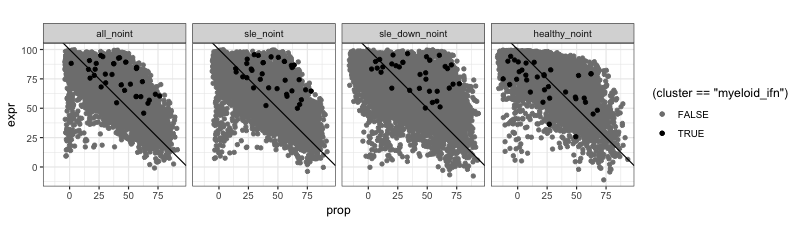

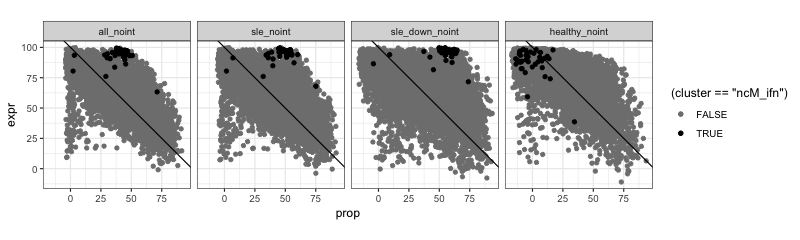

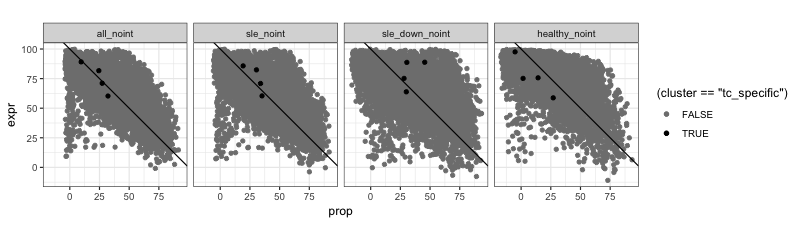

cor        prop_mean expr_mean sum_mean
all_noint      -0.7481077 25.86268  71.75159  97.61427
sle_noint      -0.7036715 27.83459  70.51765  98.35225
sle_down_noint -0.5500079 26.92723  71.91281  98.84003
healthy_noint  -0.6723116 17.41633  80.24335  97.65968

cM        Th        B        NK       ncM      Tc       
all_noint_prop       7.165910  4.083505 3.708530 1.935606 1.848803  2.093191
all_noint_expr      16.446523 11.403147 5.322387 3.033792 3.134284 10.474301
sle_noint_prop       7.133671  4.951707 4.213525 2.011148 2.064040  2.552130
sle_noint_expr      18.101796 10.190100 4.956862 2.838111 3.297087 10.070977
sle_down_noint_prop  7.033663  6.602571 5.302033 3.955714 3.111903  4.613604
sle_down_noint_expr 18.246164 11.344038 5.331273 3.367071 3.736953 11.633677
healthy_noint_prop   6.773521  3.073395 3.792244 3.962059 2.968014  2.198275
healthy_noint_expr  13.807900 17.610870 7.855162 4.713433 3.559177 13.487965
                    DC       total.r2 adj.r2  
all_noint_prop      1.710165 22.54571 25.86268
all_noint_expr      1.566752 51.38119 71.75159
sle_noint_prop      2.169362 25.09558 27.83459
sle_noint_expr      1.551193 51.00613 70.51765
sle_down_noint_prop 3.762695 34.38218 26.92723
sle_down_noint_expr 2.162417 55.82159 71.91281
healthy_noint_prop  2.712724 25.48023 17.41633
healthy_noint_expr  2.478187 63.51269 80.24335

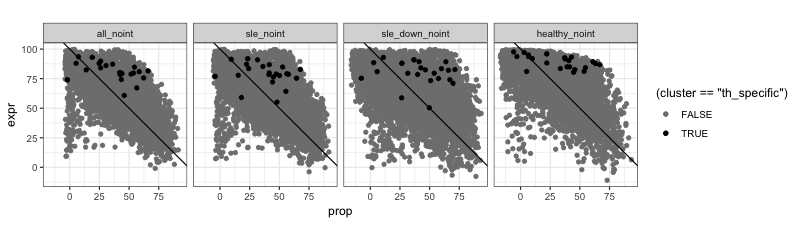

In [61]:
output_noint_df <- data.frame(prop=output_prop_noint[,"adj r2"], expr=output_expr_noint[,"adj r2"], type="all_noint")
output_noint_df$cluster <- "no_diff";
output_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_noint_df))] <- cuttree_out[,"cluster"];

output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"adj r2"], expr=output_sle_expr_noint[,"adj r2"], type="sle_noint")
output_sle_noint_df$cluster <- "no_diff";
output_sle_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_noint_df))] <- cuttree_out[,"cluster"];

output_sle_down_noint_df <- data.frame(prop=output_sle_down_prop_noint[,"adj r2"], expr=output_sle_down_expr_noint[,"adj r2"], type="sle_down_noint")
output_sle_down_noint_df$cluster <- "no_diff";
output_sle_down_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_down_noint_df))] <- cuttree_out[,"cluster"];

output_healthy_noint_df <- data.frame(prop=output_healthy_prop_noint[,"adj r2"], expr=output_healthy_expr_noint[,"adj r2"], type="healthy_noint")
output_healthy_noint_df$cluster <- "no_diff";
output_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_healthy_noint_df))] <- cuttree_out[,"cluster"];

df <- rbind(output_noint_df, output_sle_noint_df, output_sle_down_noint_df, output_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "all_ifn")] <- "no_all_ifn";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","no_all_ifn","all_ifn"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

ggplot(aes(prop, expr,color=(cluster=="all_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'all_ifn'),
             aes(x = prop, y = expr, color = (cluster=="all_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="cM_DC_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_DC_ifn'),
             aes(x = prop, y = expr, color = (cluster=="cM_DC_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="cM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_ifn'),
             aes(x = prop, y = expr, color = (cluster=="cM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="dc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'dc_specific'),
             aes(x = prop, y = expr, color = (cluster=="dc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="myeloid_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'myeloid_ifn'),
             aes(x = prop, y = expr, color = (cluster=="myeloid_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="ncM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'ncM_ifn'),
             aes(x = prop, y = expr, color = (cluster=="ncM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="tc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'tc_specific'),
             aes(x = prop, y = expr, color = (cluster=="tc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="th_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'th_specific'),
             aes(x = prop, y = expr, color = (cluster=="th_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]), cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]), cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]), cor(output_healthy_prop_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])),
      prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"])),
      expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_expr_noint[,"adj r2"])),
      sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]+output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"]+output_healthy_expr_noint[,"adj r2"])))
rownames(df2) <- c("all_noint", "sle_noint", "sle_down_noint", "healthy_noint")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
             data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_expr_noint,2,mean,na.rm=T))))

rownames(df3) <- c("all_noint_prop", "all_noint_expr", "sle_noint_prop", "sle_noint_expr", "sle_down_noint_prop", "sle_down_noint_expr", "healthy_noint_prop", "healthy_noint_expr")

df3

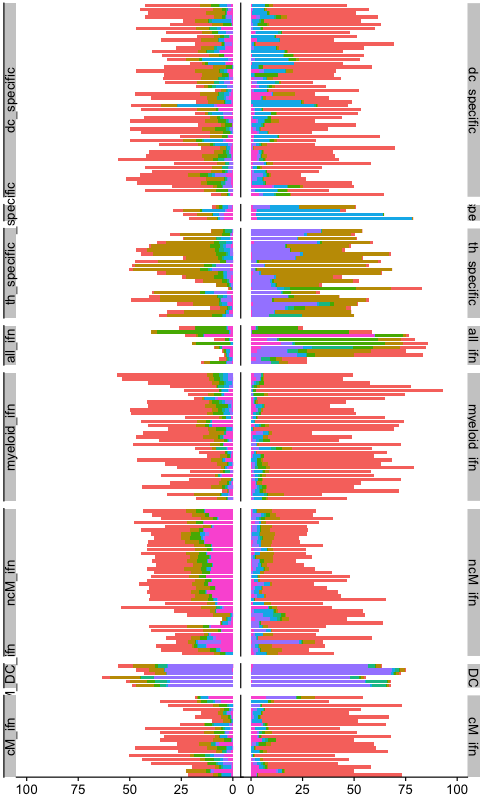

In [62]:
options(repr.plot.width = 6, repr.plot.height = 10)
out <- rbind(data.frame(gene_names=rownames(output_prop_noint), prop=output_prop_noint[,"cM"], cell="cM"),
             data.frame(gene_names=rownames(output_prop_noint), prop=output_prop_noint[,"Th"], cell="Th"),
             data.frame(gene_names=rownames(output_prop_noint), prop=output_prop_noint[,"B"], cell="B"),
             data.frame(gene_names=rownames(output_prop_noint), prop=output_prop_noint[,"NK"], cell="NK"),
             data.frame(gene_names=rownames(output_prop_noint), prop=output_prop_noint[,"ncM"], cell="ncM"),
             data.frame(gene_names=rownames(output_prop_noint), prop=output_prop_noint[,"Tc"], cell="Tc"),
             data.frame(gene_names=rownames(output_prop_noint), prop=output_prop_noint[,"DC"], cell="DC"))

##clusters_ordered <- factor(cuttree_out[,"cluster"], levels=c("dc_specific","tc_specific", "th_specific","all_ifn","myeloid_ifn","ncM_ifn","cM_DC_ifn","cM_ifn"))
##cuttree_ordered <- cuttree_out[order(clusters_ordered,decreasing=T),]
matched <- match(out$gene_names, rev(pheatmap_out$tree_row$labels[pheatmap_out$tree_row$order]))
out <- out[which(!is.na(matched)),]
out_ordered <- out[order(na.omit(matched)),]
out_ordered <- cbind(out_ordered, cluster=cuttree_out[match(out_ordered$gene_names,cuttree_out[,"gene"]),"cluster"])
out_ordered$cluster <- factor(out_ordered$cluster, levels=c('dc_specific','tc_specific','th_specific','all_ifn','myeloid_ifn','ncM_ifn','cM_DC_ifn','cM_ifn'))

out_ordered$gene_names <- factor(out_ordered$gene_names,levels=c(unique(as.character(out_ordered$gene_names))))
prop_plot <- ggplot(aes(x=gene_names,y=prop,fill=cell),data=out_ordered)+geom_bar(stat="identity")+theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(), 
        axis.text.y = element_blank(), 
        ##axis.text.y = element_text(size=5),
        axis.ticks.y = element_blank(), 
        plot.margin = unit(c(1,-1,1,0), "mm"),
        legend.position="none")+facet_grid(cluster~.,scales = "free_y",space="free_y",switch="y")+scale_y_reverse(limits=c(100,0))+coord_flip()

options(repr.plot.width = 6, repr.plot.height = 10)
out_expr <- rbind(data.frame(gene_names=rownames(output_expr_noint), prop=output_expr_noint[,"cM"], cell="cM"),
             data.frame(gene_names=rownames(output_expr_noint), prop=output_expr_noint[,"Th"], cell="Th"),
             data.frame(gene_names=rownames(output_expr_noint), prop=output_expr_noint[,"B"], cell="B"),
             data.frame(gene_names=rownames(output_expr_noint), prop=output_expr_noint[,"NK"], cell="NK"),
             data.frame(gene_names=rownames(output_expr_noint), prop=output_expr_noint[,"ncM"], cell="ncM"),
             data.frame(gene_names=rownames(output_expr_noint), prop=output_expr_noint[,"Tc"], cell="Tc"),
             data.frame(gene_names=rownames(output_expr_noint), prop=output_expr_noint[,"DC"], cell="DC"))
##cuttree_ordered <- cuttree_out[order(cuttree_out[,"cluster"]),]
matched_expr <- match(out_expr$gene_names, rev(pheatmap_out$tree_row$labels[pheatmap_out$tree_row$order]))
out_expr <- out_expr[which(!is.na(matched)),]
out_expr_ordered <- out_expr[order(na.omit(matched)),]
out_expr_ordered <- cbind(out_expr_ordered, cluster=cuttree_out[match(out_expr_ordered$gene_names,cuttree_out[,"gene"]),"cluster"])
out_expr_ordered$cluster <- factor(out_expr_ordered$cluster, levels=c('dc_specific','tc_specific','th_specific','all_ifn','myeloid_ifn','ncM_ifn','cM_DC_ifn','cM_ifn'))

out_expr_ordered$gene_names <- factor(out_expr_ordered$gene_names,levels=c(unique(as.character(out_expr_ordered$gene_names))))
expr_plot <- ggplot(aes(x=gene_names,y=prop,fill=cell),data=out_expr_ordered)+geom_bar(stat="identity")+ylim(0,100)+theme(axis.title.x = element_blank(), axis.title.y = element_blank(), 
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        plot.margin = unit(c(1,0,1,-1), "mm"),legend.position="none")+facet_grid(cluster~.,scales = "free_y",space="free_y")+coord_flip()

library(gridExtra)
gg1 <- ggplot_gtable(ggplot_build(prop_plot))
gg2 <- ggplot_gtable(ggplot_build(expr_plot))

grid.arrange(gg1,gg2,ncol=2,widths=c(4/9,4/9))


##ggplot(aes(x=gene_names,y=prop,fill=cell),data=out_ordered)+geom_bar(stat="identity")+facet_grid(~cluster,scales = "free_x", space = "free_x")

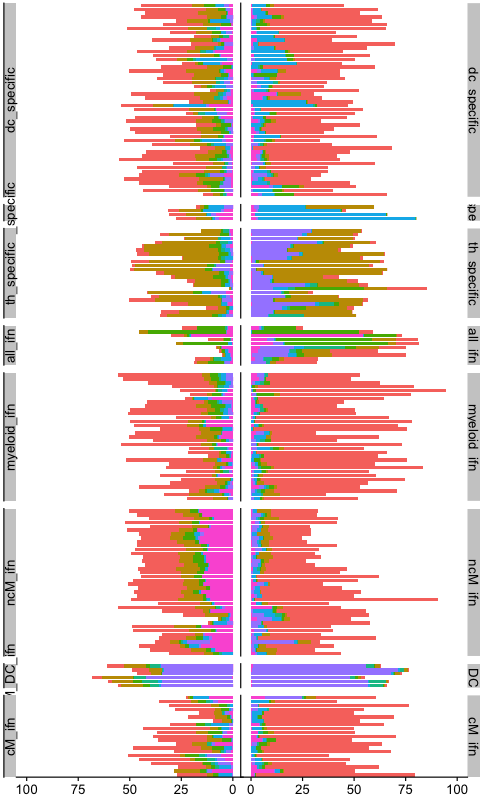

In [63]:
options(repr.plot.width = 6, repr.plot.height = 10)
out_sle_prop <- rbind(data.frame(gene_names=rownames(output_sle_prop_noint), prop=output_sle_prop_noint[,"cM"], cell="cM"),
             data.frame(gene_names=rownames(output_sle_prop_noint), prop=output_sle_prop_noint[,"Th"], cell="Th"),
             data.frame(gene_names=rownames(output_sle_prop_noint), prop=output_sle_prop_noint[,"B"], cell="B"),
             data.frame(gene_names=rownames(output_sle_prop_noint), prop=output_sle_prop_noint[,"NK"], cell="NK"),
             data.frame(gene_names=rownames(output_sle_prop_noint), prop=output_sle_prop_noint[,"ncM"], cell="ncM"),
             data.frame(gene_names=rownames(output_sle_prop_noint), prop=output_sle_prop_noint[,"Tc"], cell="Tc"),
             data.frame(gene_names=rownames(output_sle_prop_noint), prop=output_sle_prop_noint[,"DC"], cell="DC"))

##cuttree_ordered <- cuttree_out[order(cuttree_out[,"cluster"]),]
##matched <- match(out_sle_prop$gene_names, rownames(cuttree_ordered))

matched <- match(out_sle_prop$gene_names, rev(pheatmap_out$tree_row$labels[pheatmap_out$tree_row$order]))
out_sle_prop <- out_sle_prop[which(!is.na(matched)),]
out_sle_prop_ordered <- out_sle_prop[order(na.omit(matched)),]
out_sle_prop_ordered <- cbind(out_sle_prop_ordered, cluster=cuttree_out[match(out_sle_prop_ordered$gene_names,cuttree_out[,"gene"]),"cluster"])
out_sle_prop_ordered$cluster <- factor(out_sle_prop_ordered$cluster, levels=c('dc_specific','tc_specific','th_specific','all_ifn','myeloid_ifn','ncM_ifn','cM_DC_ifn','cM_ifn'))

out_sle_prop_ordered$gene_names <- factor(out_sle_prop_ordered$gene_names,levels=c(unique(as.character(out_sle_prop_ordered$gene_names))))
sle_prop_plot <- ggplot(aes(x=gene_names,y=prop,fill=cell),data=out_sle_prop_ordered)+geom_bar(stat="identity")+theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(), 
        axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        plot.margin = unit(c(1,-1,1,0), "mm"),
        legend.position="none")+facet_grid(cluster~.,scales = "free_y",space="free_y",switch="y")+scale_y_reverse(limits=c(100,0))+coord_flip()


options(repr.plot.width = 6, repr.plot.height = 10)
out_sle_expr <- rbind(data.frame(gene_names=rownames(output_sle_expr_noint), prop=output_sle_expr_noint[,"cM"], cell="cM"),
             data.frame(gene_names=rownames(output_sle_expr_noint), prop=output_sle_expr_noint[,"Th"], cell="Th"),
             data.frame(gene_names=rownames(output_sle_expr_noint), prop=output_sle_expr_noint[,"B"], cell="B"),
             data.frame(gene_names=rownames(output_sle_expr_noint), prop=output_sle_expr_noint[,"NK"], cell="NK"),
             data.frame(gene_names=rownames(output_sle_expr_noint), prop=output_sle_expr_noint[,"ncM"], cell="ncM"),
             data.frame(gene_names=rownames(output_sle_expr_noint), prop=output_sle_expr_noint[,"Tc"], cell="Tc"),
             data.frame(gene_names=rownames(output_sle_expr_noint), prop=output_sle_expr_noint[,"DC"], cell="DC"))
##cuttree_ordered <- cuttree_out[order(cuttree_out[,"cluster"]),]

matched_expr <- match(out_sle_expr$gene_names, rev(pheatmap_out$tree_row$labels[pheatmap_out$tree_row$order]))
out_sle_expr <- out_sle_expr[which(!is.na(matched)),]
out_sle_expr_ordered <- out_sle_expr[order(na.omit(matched)),]
out_sle_expr_ordered <- cbind(out_sle_expr_ordered, cluster=cuttree_out[match(out_sle_expr_ordered$gene_names,cuttree_out[,"gene"]),"cluster"])
out_sle_expr_ordered$cluster <- factor(out_sle_expr_ordered$cluster, levels=c('dc_specific','tc_specific','th_specific','all_ifn','myeloid_ifn','ncM_ifn','cM_DC_ifn','cM_ifn'))

out_sle_expr_ordered$gene_names <- factor(out_sle_expr_ordered$gene_names,levels=c(unique(as.character(out_sle_expr_ordered$gene_names))))
sle_expr_plot <- ggplot(aes(x=gene_names,y=prop,fill=cell),data=out_sle_expr_ordered)+geom_bar(stat="identity")+ylim(0,100)+coord_flip()+theme(axis.title.x = element_blank(), axis.title.y = element_blank(), 
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        plot.margin = unit(c(1,0,1,-1), "mm"),legend.position="none")+facet_grid(cluster~.,scales = "free_y",space="free_y")

library(gridExtra)
gg1 <- ggplot_gtable(ggplot_build(sle_prop_plot))
gg2 <- ggplot_gtable(ggplot_build(sle_expr_plot))

grid.arrange(gg1,gg2,ncol=2,widths=c(4/9,4/9))

Warning message:
“Removed 4 rows containing missing values (geom_bar).”

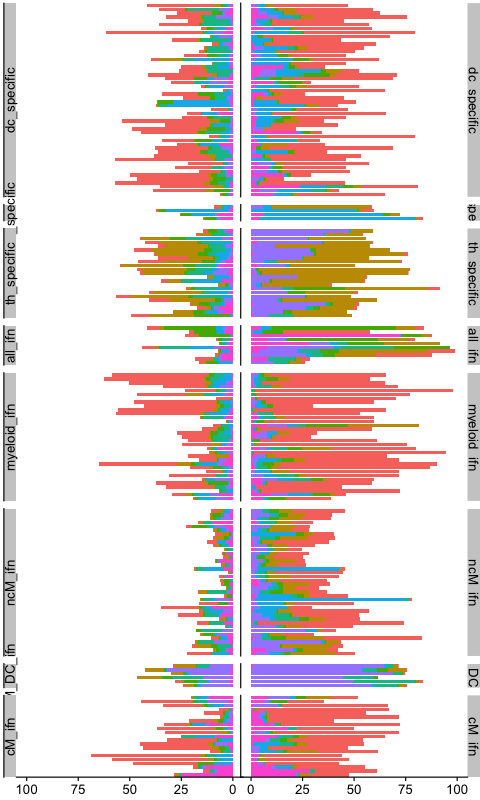

In [64]:
options(repr.plot.width = 6, repr.plot.height = 10)
out_healthy_prop <- rbind(data.frame(gene_names=rownames(output_healthy_prop_noint), prop=output_healthy_prop_noint[,"cM"], cell="cM"),
             data.frame(gene_names=rownames(output_healthy_prop_noint), prop=output_healthy_prop_noint[,"Th"], cell="Th"),
             data.frame(gene_names=rownames(output_healthy_prop_noint), prop=output_healthy_prop_noint[,"B"], cell="B"),
             data.frame(gene_names=rownames(output_healthy_prop_noint), prop=output_healthy_prop_noint[,"NK"], cell="NK"),
             data.frame(gene_names=rownames(output_healthy_prop_noint), prop=output_healthy_prop_noint[,"ncM"], cell="ncM"),
             data.frame(gene_names=rownames(output_healthy_prop_noint), prop=output_healthy_prop_noint[,"Tc"], cell="Tc"),
             data.frame(gene_names=rownames(output_healthy_prop_noint), prop=output_healthy_prop_noint[,"DC"], cell="DC"))

matched <- match(out_healthy_prop$gene_names, rev(pheatmap_out$tree_row$labels[pheatmap_out$tree_row$order]))
out_healthy_prop <- out_healthy_prop[which(!is.na(matched)),]
out_healthy_prop_ordered <- out_healthy_prop[order(na.omit(matched)),]
out_healthy_prop_ordered <- cbind(out_healthy_prop_ordered, cluster=cuttree_out[match(out_healthy_prop_ordered$gene_names,cuttree_out[,"gene"]),"cluster"])
out_healthy_prop_ordered$cluster <- factor(out_healthy_prop_ordered$cluster, levels=c('dc_specific','tc_specific','th_specific','all_ifn','myeloid_ifn','ncM_ifn','cM_DC_ifn','cM_ifn'))

out_healthy_prop_ordered$gene_names <- factor(out_healthy_prop_ordered$gene_names,levels=c(unique(as.character(out_healthy_prop_ordered$gene_names))))
healthy_prop_plot <- ggplot(aes(x=gene_names,y=prop,fill=cell),data=out_healthy_prop_ordered)+geom_bar(stat="identity")+theme(axis.title.x = element_blank(), 
        axis.title.y = element_blank(), 
        axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        plot.margin = unit(c(1,-1,1,0), "mm"),
        legend.position="none")+facet_grid(cluster~.,scales = "free_y",space="free_y",switch="y")+scale_y_reverse(limits=c(100,0))+coord_flip()

options(repr.plot.width = 6, repr.plot.height = 10)
out_healthy_expr <- rbind(data.frame(gene_names=rownames(output_healthy_expr_noint), prop=output_healthy_expr_noint[,"cM"], cell="cM"),
             data.frame(gene_names=rownames(output_healthy_expr_noint), prop=output_healthy_expr_noint[,"Th"], cell="Th"),
             data.frame(gene_names=rownames(output_healthy_expr_noint), prop=output_healthy_expr_noint[,"B"], cell="B"),
             data.frame(gene_names=rownames(output_healthy_expr_noint), prop=output_healthy_expr_noint[,"NK"], cell="NK"),
             data.frame(gene_names=rownames(output_healthy_expr_noint), prop=output_healthy_expr_noint[,"ncM"], cell="ncM"),
             data.frame(gene_names=rownames(output_healthy_expr_noint), prop=output_healthy_expr_noint[,"Tc"], cell="Tc"),
             data.frame(gene_names=rownames(output_healthy_expr_noint), prop=output_healthy_expr_noint[,"DC"], cell="DC"))
##cuttree_ordered <- cuttree_out[order(cuttree_out[,"cluster"]),]
matched_expr <- match(out_healthy_expr$gene_names, rev(pheatmap_out$tree_row$labels[pheatmap_out$tree_row$order]))
out_healthy_expr <- out_healthy_expr[which(!is.na(matched)),]
out_healthy_expr_ordered <- out_healthy_expr[order(na.omit(matched)),]
out_healthy_expr_ordered <- cbind(out_healthy_expr_ordered, cluster=cuttree_out[match(out_healthy_expr_ordered$gene_names,cuttree_out[,"gene"]),"cluster"])
out_healthy_expr_ordered$cluster <- factor(out_healthy_expr_ordered$cluster, levels=c('dc_specific','tc_specific','th_specific','all_ifn','myeloid_ifn','ncM_ifn','cM_DC_ifn','cM_ifn'))

out_healthy_expr_ordered$gene_names <- factor(out_healthy_expr_ordered$gene_names,levels=c(unique(as.character(out_healthy_expr_ordered$gene_names))))
healthy_expr_plot <- ggplot(aes(x=gene_names,y=prop,fill=cell),data=out_healthy_expr_ordered)+geom_bar(stat="identity")+ylim(0,100)+coord_flip()+theme(axis.title.x = element_blank(), axis.title.y = element_blank(), 
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        plot.margin = unit(c(1,0,1,-1), "mm"),legend.position="none")+facet_grid(cluster~.,scales = "free_y",space="free_y")

library(gridExtra)
gg1 <- ggplot_gtable(ggplot_build(healthy_prop_plot))
gg2 <- ggplot_gtable(ggplot_build(healthy_expr_plot))

grid.arrange(gg1,gg2,ncol=2,widths=c(4/9,4/9))

In [65]:
c(unique(as.character(out_ordered$gene_names)))

[1] "GRASP"          "DENND3"         "EGR3"           "FXYD6"         
  [5] "NFE2"           "IL10"           "CTA-384D8.35"   "RP11-536K7.3"  
  [9] "TNFAIP6"        "TMEM150B"       "EPHB2"          "SERINC2"       
 [13] "THBS1"          "SEMA6B"         "DYSF"           "NFIL3"         
 [17] "PLSCR1"         "LAP3"           "SAP30"          "HESX1"         
 [21] "SIGLEC1"        "SLC1A3"         "CLEC4D"         "C19orf59"      
 [25] "CLEC4E"         "S100A12"        "NRG1"           "RP11-481A20.11"
 [29] "HP"             "SERPINB2"       "MARC1"          "S100A8"        
 [33] "S100A9"         "IL1R2"          "VSIG4"          "HOXA5"         
 [37] "PLA2G7"         "QPCT"           "MGST1"          "LRG1"          
 [41] "CD163"          "VEGFA"          "ANG"            "RNASE1"        
 [45] "AP003774.6"     "RNASE2"         "PRKCDBP"        "RP11-1143G9.4" 
 [49] "THBD"           "HBEGF"          "EREG"           "CES1"          
 [53] "ID1"            "SERPINF1"       "PLA1A"          "SIGLEC9"       
 [57] "SDSL"           "PLBD1"          "TNFSF13B"       "IGSF6"         
 [61] "NLRP3"          "IL1RN"          "RAB20"          "BST1"          
 [65] "PRRG4"          "FCGR1A"         "RETN"           "LILRA5"        
 [69] "SECTM1"         "CXCL10"         "FPR1"           "FCN1"          
 [73] "MARCO"          "MEFV"           "FCGR1B"         "P2RY2"         
 [77] "SERPING1"       "MS4A4A"         "MSR1"           "SCO2"          
 [81] "TYMP"           "G0S2"           "NR4A1"          "CDKN1A"        
 [85] "ATF3"           "CTA-384D8.34"   "SAMD4A"         "JDP2"          
 [89] "LILRA3"         "MRVI1"          "FPR2"           "FFAR2"         
 [93] "C2"             "VSTM1"          "APOBEC3A"       "APOBEC3B"      
 [97] "HGF"            "EXOC3L1"        "LINC00482"      "HSPA6"         
[101] "FLVCR2"         "TCN2"           "ADM"            "LILRA6"        
[105] "C1QC"           "C1QB"           "C1QA"           "SCGB3A1"       
[109] "CH25H"          "SPATS2L"        "LGALS3BP"       "MT1E"          
[113] "OTOF"           "GBP1"           "MT2A"           "OASL"          
[117] "CCL3L3"         "SMAD7"          "GOLM1"          "ANKRD22"       
[121] "BLVRA"          "TNFSF10"        "IFITM3"         "IFIT2"         
[125] "RSAD2"          "OAS3"           "OAS2"           "CMPK2"         
[129] "IFIT1"          "IFIT3"          "OAS1"           "MX1"           
[133] "XAF1"           "IFI44L"         "ISG15"          "IFI6"          
[137] "IFI44"          "LY6E"           "USP18"          "IFI27"         
[141] "PARP9"          "STAT1"          "MX2"            "ETV7"          
[145] "HELZ2"          "HERC5"          "UTS2"           "AREG"          
[149] "LRRC26"         "SCT"            "SMPD3"          "CLEC4C"        
[153] "LILRA4"         "DNASE1L3"       "IL6"            "RP5-887A10.1"  
[157] "RP11-305L7.1"   "RP11-305L7.3"   "GZMH"           "ZNF683"        
[161] "KIF19"          "IFNG"           "AK5"            "TMEM204"       
[165] "AC021860.1"     "SPINK2"         "MDS2"           "CCR7"          
[169] "MYC"            "PTPRS"          "LAPTM4B"        "COL18A1"       
[173] "CELA1"          "ANKRD55"        "ADTRP"          "FHIT"          
[177] "TSHZ2"          "RP11-641A6.2"   "RP11-161M6.2"   "EPHX2"         
[181] "FAM153B"        "SLC16A10"       "LRRN3"          "PASK"          
[185] "CPA5"

In [66]:
r2 <- cbind(output_sle_down_prop_noint[,"adj r2"],output_healthy_prop_noint[,"adj r2"])
r2[order(apply(r2,1,mean),decreasing=T),]

[,1]       [,2]      
CD79A         90.62191   93.43275  
RALGPS2       92.63377   89.48462  
PAX5          90.39195   88.82253  
CD3E          90.15778   88.86743  
FAM129C       91.75101   86.40361  
AFF3          93.24535   84.71008  
LST1          88.03761   87.67796  
STRBP         92.04619   83.59905  
CD74          84.48521   91.14527  
TYROBP        88.83904   85.03082  
CD37          93.28122   80.50376  
BANK1         86.64844   86.72539  
EBF1          90.08939   82.56482  
KLRF1         86.97496   84.91373  
GNG7          89.08920   82.67266  
AP2S1         90.17757   78.72428  
KIAA0226L     89.92776   78.44122  
CD68          82.42064   85.28383  
OAZ1          84.57416   83.03866  
CST3          86.21738   81.14136  
CYBB          88.46727   78.62465  
CTSS          83.11734   83.70447  
CDKN1C        77.41471   89.26976  
H2AFY         83.24063   83.31190  
CD22          89.00151   77.49709  
S100A6        81.05510   85.23871  
CD3D          78.65981   86.98670  
MS4A1         84.70746   80.66385  
POU2AF1       84.10005   81.25422  
CD19          87.15652   77.97400  
⋮             ⋮          ⋮         
TVP23C         -9.754421 -10.392738
NOMO3         -12.559293  -7.596992
CWC22         -12.807341  -7.412149
FAM189B        -8.535846 -11.722816
NUP85          -8.501679 -11.764019
IKBKAP        -11.413173  -8.869974
C2CD3          -4.869625 -15.465555
PCP2           -6.336280 -14.043999
GIGYF2         -9.924026 -10.551309
MANEA         -10.766107  -9.965911
ASMTL          -6.932856 -13.989726
POLR3H         -8.782486 -12.231302
ANAPC2         -7.575102 -13.665079
RMDN1         -12.595311  -8.665583
NUDT2          -6.887280 -14.910616
RP11-262H14.3 -14.599301  -7.514166
SMCR5          -8.651851 -13.464063
RANBP9        -12.982218  -9.155193
NADK2         -15.337545  -7.011085
GTF2H1        -10.906582 -11.594896
ZDHHC17       -16.088435  -6.420250
CHCHD3         -7.764764 -14.766560
GTF2A1        -13.361702  -9.280161
TMX3           -9.681187 -13.106522
SLC25A35      -13.165640  -9.945073
AL139099.1    -11.086262 -12.911289
ZNF18         -13.035424 -11.174079
ACCS          -13.408509 -12.965373
TBCEL         -11.421006 -15.727012
CALD1         -11.875595 -16.050841

In [67]:
r2 <- cbind(output_sle_down_expr_noint[,"adj r2"],output_healthy_expr_noint[,"adj r2"])
r2[order(apply(r2,1,mean),decreasing=T),]

[,1]       [,2]      
RPS26         99.51821   99.50845  
RP1-3J17.3    99.39463   99.56846  
EIF5A         98.90030   99.27960  
FAM118A       98.58872   99.53713  
AL592183.1    98.75861   99.24553  
XAF1          99.56275   98.30541  
ERAP2         98.39541   99.03411  
EIF2AK2       99.59155   97.75746  
NUDT2         98.78223   98.51620  
RP11-262H14.3 98.03287   99.22607  
HLA-DQA2      98.33974   98.80982  
KANSL1-AS1    97.86787   99.10314  
YBEY          97.98377   98.87984  
LINC00969     97.88972   98.74792  
HLA-B         97.85623   98.60919  
IFI44L        99.56031   96.66646  
MX1           99.20529   96.97782  
FAM184B       97.50076   98.60744  
SLC2A14       97.13173   98.88731  
PPDPF         98.84036   97.16840  
RP11-347P5.1  96.55496   99.40979  
HLA-DRB5      97.96275   97.96864  
MT-ATP6       98.44119   97.47796  
RBM3          97.24112   98.67002  
ELP5          97.21821   98.58769  
GSTT1         97.41808   98.31415  
MT-ND5        97.96043   97.71563  
ZFP57         97.29813   98.37570  
PARP9         97.91034   97.61989  
RP11-298J20.3 97.40987   98.08641  
⋮             ⋮          ⋮         
PTCRA         18.0378023   9.558184
TYROBP         4.3381272  23.223525
SNX22         16.8352520  10.648119
ASAH1          4.7834247  21.361521
GP9            9.8011623  15.765836
TYMS           8.6945735  16.862537
NUMB          15.6270619   9.549280
RALGPS2        5.7748649  18.422424
HLA-DOB       34.0830240 -10.988480
CLEC1B         9.8051540  13.256832
COBLL1         0.9484266  21.133528
EHBP1L1       12.3442703   9.503589
TMEM40         9.2254515  11.722611
PLXNB2        -0.5934101  21.054570
PILRA         15.6571884   4.074803
GNAI2          0.7982990  18.868711
RASGRP3       10.1961952   7.335683
MCTP1          4.3678106  11.551570
EBF1           6.6873952   8.964170
CCDC88A        9.5163735   5.619909
PRKACA        11.8406197  -2.111958
C19orf38       1.3736028   7.869643
POU2AF1       -2.0583039  10.774177
PNOC           7.9592064  -1.490036
PICALM         1.5332568   3.470100
KIAA0125      -0.4862286   5.367418
ADRBK2        -6.6694452  11.180894
GNG7          -7.6871000  11.288453
DMXL2          7.1170782  -4.284017
BLK            2.7300308  -1.152909

In [68]:
r2.rat <- cbind(output_sle_down_prop_noint[,"total r2"]/(output_sle_down_expr_noint[,"total r2"]+output_sle_down_prop_noint[,"total r2"]),
                output_healthy_prop_noint[,"total r2"]/(output_healthy_expr_noint[,"total r2"]+output_healthy_prop_noint[,"total r2"]))
r2.rat["NKG7",]

[1] 0.6582485 0.5810906

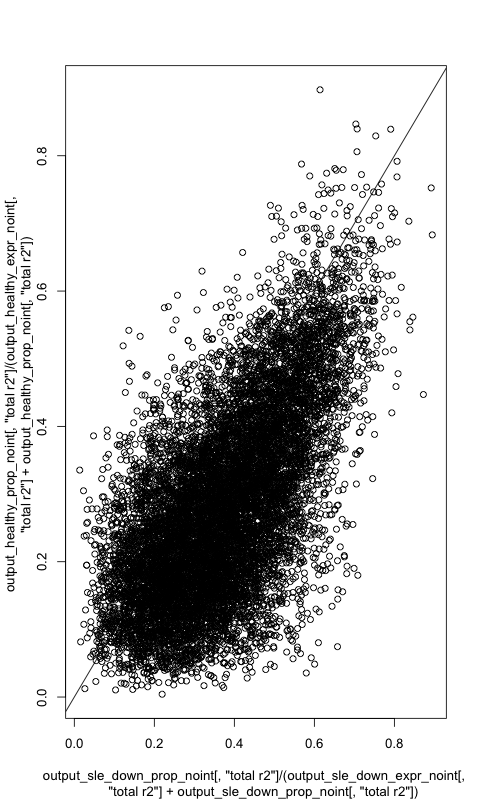

In [69]:
## look for cell type proportion genes
plot(output_sle_down_prop_noint[,"total r2"]/(output_sle_down_expr_noint[,"total r2"]+output_sle_down_prop_noint[,"total r2"]),
output_healthy_prop_noint[,"total r2"]/(output_healthy_expr_noint[,"total r2"]+output_healthy_prop_noint[,"total r2"]))
abline(a=0,b=1)


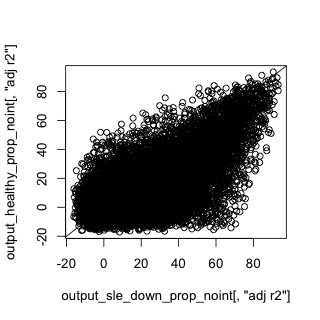

In [70]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_down_prop_noint[,"adj r2"], output_healthy_prop_noint[,"adj r2"])
abline(b=1,a=0)

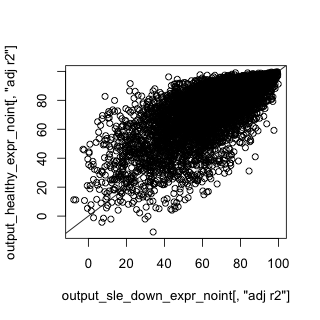

In [71]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_down_expr_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])
abline(b=1,a=0)

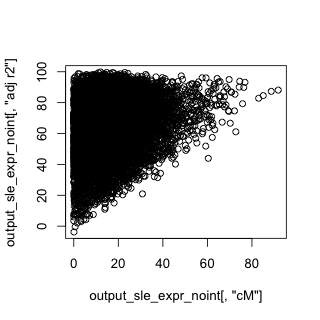

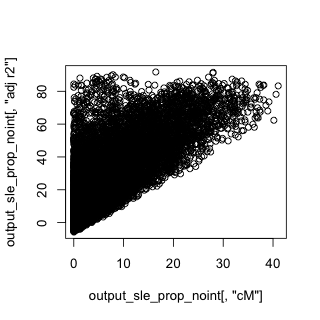

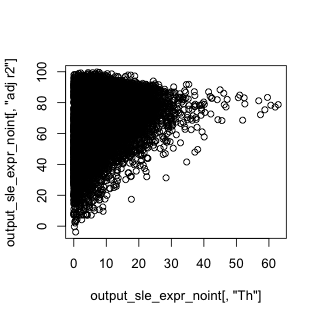

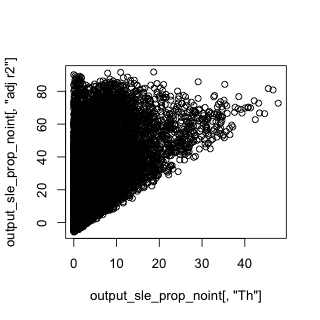

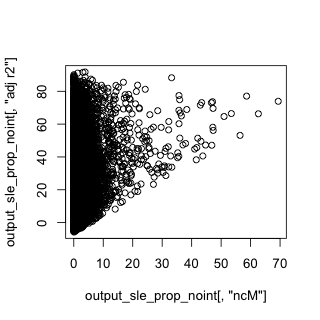

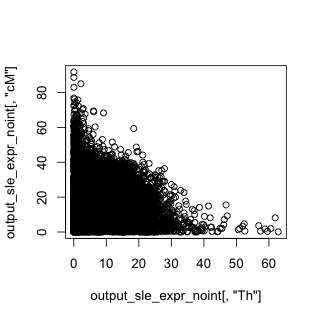

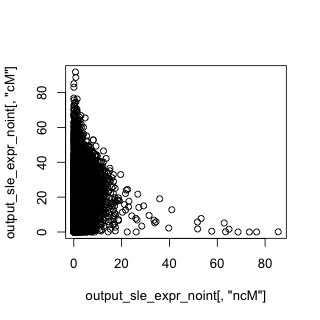

In [72]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_expr_noint[,"cM"], output_sle_expr_noint[,"adj r2"])
plot(output_sle_prop_noint[,"cM"], output_sle_prop_noint[,"adj r2"])
plot(output_sle_expr_noint[,"Th"], output_sle_expr_noint[,"adj r2"])
plot(output_sle_prop_noint[,"Th"], output_sle_prop_noint[,"adj r2"])
plot(output_sle_prop_noint[,"ncM"], output_sle_prop_noint[,"adj r2"])
plot(output_sle_expr_noint[,"Th"], output_sle_expr_noint[,"cM"])
plot(output_sle_expr_noint[,"ncM"], output_sle_expr_noint[,"cM"])


# Let's do the estimation using resampling

We are going to work with counts here. Given the expression of an arbitrary gene $i$ and individual $j$ in PBMCs $P$, and two cell types (B and T) for simplicity. $N_j^B$ and $N_j^T$ are the number of B cells and T cells for individual $j$.

\begin{align*}
P_{ij} &= B_{ij1}+B_{ij2}+...+B_{ijN_b}+T_{ij1}+T_{ij2}+...+T_{ijN_t} \\
P_{ij} &= \sum_k^{N_j^B}B_{ijk} + \sum_k^{N_j^T}T_{ijk} \\
P_{ij} &= N_j^B\times{\bar{B}_{ij}} + N_j^T\times{\bar{T}_{ij}} \\
\bar{P_{ij}} &= {{N_j^B}\over{N_j^{PBMC}}}\times{\bar{B_{ij}}} + {{N_j^T}\over{N_j^{PBMC}}}\times{\bar{T_{ij}}} \\
\bar{P_{ij}} &= {{{\rho}_j^B}\times{\bar{B_{ij}}} + {{\rho}_j^T}\times{\bar{T_{ij}}}}
\end{align*}


$\bar{B}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type B. $\bar{T}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type T

First, fit proportion

\begin{align*}
\bar{P_{ij}} &= {{\rho}_j^B}\times{\bar{B_{i}}} + {{\rho}_j^T}\times{\bar{T_{i}}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{B_{i}} = {{\sum_j^{J}\bar{B_{ij}}}\over{J}}$

Second, fit expression

\begin{align*}
\bar{P_{ij}} &= {\bar{{\rho}^B}}\times{B_{ij}} + {\bar{{\rho}^T}}\times{T_{ij}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{{\rho}^B} = {{{\sum_j^{J}{\rho_j^B}}}\over{J}}$


## First, let's do all individuals

In [73]:
##joined_pivot_filtered <- joined_pivot[match(colnames(pbmc_expr),joined_pivot$ind_cov),]
# cm_counts_mean <- sweep(exp(cm_expr), 2, joined_pivot_filtered$counts*cm_prop/100, "/")
# th_counts_mean <- sweep(exp(th_expr), 2, joined_pivot_filtered$counts*th_prop/100, "/")
# tc_counts_mean <- sweep(exp(tc_expr), 2, joined_pivot_filtered$counts*tc_prop/100, "/")
# b_counts_mean <- sweep(exp(b_expr), 2, joined_pivot_filtered$counts*b_prop/100, "/")
# nk_counts_mean <- sweep(exp(nk_expr), 2, joined_pivot_filtered$counts*nk_prop/100, "/")
# ncm_counts_mean <- sweep(exp(ncm_expr), 2, joined_pivot_filtered$counts*ncm_prop/100, "/")
# dc_counts_mean <- sweep(exp(dc_expr), 2, joined_pivot_filtered$counts*dc_prop/100, "/")
# pbmc_counts_mean <- sweep(exp(pbmc_expr), 2, joined_pivot_filtered$counts, "/")

cm_counts_mean <- exp(cm_expr)
th_counts_mean <- exp(th_expr)
tc_counts_mean <- exp(tc_expr)
b_counts_mean <- exp(b_expr)
nk_counts_mean <- exp(nk_expr)
ncm_counts_mean <- exp(ncm_expr)
dc_counts_mean <- exp(dc_expr)
pbmc_counts_mean <- exp(pbmc_expr)


## some samples do not have b cells or dcs, let's set those means to 0
b_counts_mean[is.nan(b_counts_mean)] <- 0;
dc_counts_mean[is.nan(dc_counts_mean)] <- 0;
b_counts_mean[!is.finite(b_counts_mean)] <- 0;
dc_counts_mean[!is.finite(dc_counts_mean)] <- 0;

# cm_counts_global_mean <- rowSums(exp(cm_expr))/sum(joined_pivot_filtered$counts*cm_prop/100, na.rm=T)
# th_counts_global_mean <- rowSums(exp(th_expr))/sum(joined_pivot_filtered$counts*th_prop/100, na.rm=T)
# tc_counts_global_mean <- rowSums(exp(tc_expr))/sum(joined_pivot_filtered$counts*tc_prop/100, na.rm=T)
# b_counts_global_mean <- rowSums(exp(b_expr))/sum(joined_pivot_filtered$counts*b_prop/100, na.rm=T)
# nk_counts_global_mean <- rowSums(exp(nk_expr))/sum(joined_pivot_filtered$counts*nk_prop/100, na.rm=T)
# ncm_counts_global_mean <- rowSums(exp(ncm_expr))/sum(joined_pivot_filtered$counts*ncm_prop/100, na.rm=T)
# dc_counts_global_mean <- rowSums(exp(dc_expr))/sum(joined_pivot_filtered$counts*dc_prop/100, na.rm=T)

cm_counts_global_mean <- apply(exp(cm_expr),1,mean)
th_counts_global_mean <- apply(exp(th_expr),1,mean)
tc_counts_global_mean <- apply(exp(tc_expr),1,mean)
b_counts_global_mean <- apply(exp(b_expr),1,mean)
nk_counts_global_mean <- apply(exp(nk_expr),1,mean)
ncm_counts_global_mean <- apply(exp(ncm_expr),1,mean)
dc_counts_global_mean <- apply(exp(dc_expr),1,mean)


a <- cbind(cm_counts_global_mean, th_counts_global_mean, tc_counts_global_mean, b_counts_global_mean, nk_counts_global_mean, ncm_counts_global_mean, dc_counts_global_mean)
##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

output_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {    
    predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
                               th_counts_global_mean[i]*th_prop/100, 
                               b_counts_global_mean[i]*b_prop/100, 
                               nk_counts_global_mean[i]*nk_prop/100, 
                               ncm_counts_global_mean[i]*ncm_prop/100, 
                               tc_counts_global_mean[i]*tc_prop/100,##), na.rm=T)
                               dc_counts_global_mean[i]*dc_prop/100), na.rm=T)

    output_direct_global_prop <- rbind(output_direct_global_prop, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
}


rownames(output_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_direct_global_prop) <- c("r2", "res")

output_direct_global_expr <- NULL;

cm_prop_global_mean <- sum(joined_pivot_filtered$counts*cm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
th_prop_global_mean <- sum(joined_pivot_filtered$counts*th_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
tc_prop_global_mean <- sum(joined_pivot_filtered$counts*tc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
b_prop_global_mean <- sum(joined_pivot_filtered$counts*b_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
nk_prop_global_mean <- sum(joined_pivot_filtered$counts*nk_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
ncm_prop_global_mean <- sum(joined_pivot_filtered$counts*ncm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
dc_prop_global_mean <- sum(joined_pivot_filtered$counts*dc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)

a_prop <- c(cm_prop_global_mean, th_prop_global_mean, tc_prop_global_mean, b_prop_global_mean, nk_prop_global_mean, ncm_prop_global_mean, dc_prop_global_mean);

for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
                              th_counts_mean[i,]*th_prop_global_mean, 
                              b_counts_mean[i,]*b_prop_global_mean,
                              nk_counts_mean[i,]*nk_prop_global_mean, 
                               ncm_counts_mean[i,]*ncm_prop_global_mean,
                              tc_counts_mean[i,]*tc_prop_global_mean,##), na.rm=T)
                              dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)

    output_direct_global_expr <- rbind(output_direct_global_expr, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
}

rownames(output_direct_global_expr) <- expr_gene_names;
colnames(output_direct_global_expr) <- c("r2", "res")

Warning message in log(predicted):
“NaNs produced”Warning message in log(predicted):
“NaNs produced”Warning message in log(predicted):
“NaNs produced”Warning message in log(predicted):
“NaNs produced”

[1] 0.8922793

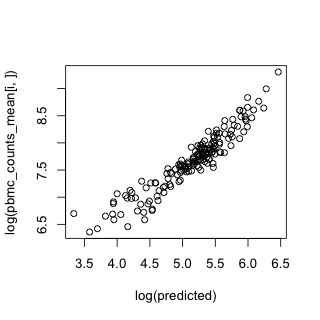

[1] 0.3976088

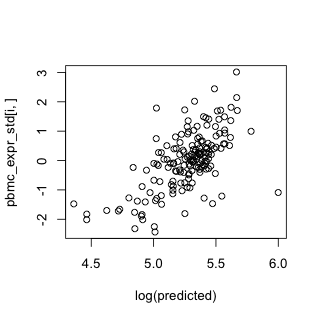

[1] 0.9447487

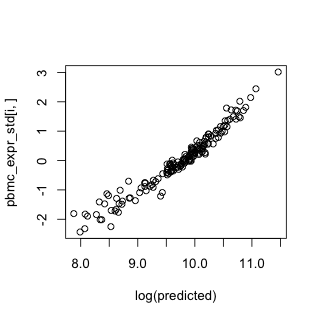

In [74]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=10
i=grep("^CD22$",expr_gene_names)[1]
##i=grep("ERAP2",expr_gene_names)[1]
predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
                               th_counts_global_mean[i]*th_prop/100,
                               b_counts_global_mean[i]*b_prop/100,
                               nk_counts_global_mean[i]*nk_prop/100, 
                               ncm_counts_global_mean[i]*ncm_prop/100,
                               tc_counts_global_mean[i]*tc_prop/100,
                     dc_counts_global_mean[i]*dc_prop/100),na.rm=T)
plot(log(predicted), log(pbmc_counts_mean[i,]))
cor(log(predicted), pbmc_expr_std[i,])^2

predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
                              th_counts_mean[i,]*th_prop_global_mean, 
                              b_counts_mean[i,]*b_prop_global_mean,
                              nk_counts_mean[i,]*nk_prop_global_mean, 
                               ncm_counts_mean[i,]*ncm_prop_global_mean,
                              tc_counts_mean[i,]*tc_prop_global_mean,
                          dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)
plot(log(predicted), pbmc_expr_std[i,])
cor(log(predicted), pbmc_expr_std[i,])^2


predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop, 
                              th_counts_mean[i,]*th_prop, 
                              b_counts_mean[i,]*b_prop,
                              nk_counts_mean[i,]*nk_prop, 
                               ncm_counts_mean[i,]*ncm_prop,
                              tc_counts_mean[i,]*tc_prop,
                          dc_counts_mean[i,]*dc_prop), na.rm=T)
plot(log(predicted), pbmc_expr_std[i,])
cor(log(predicted), pbmc_expr_std[i,])^2

## Second, let's do SLE

Mean of means might be a bit unstable, let's calculate a global mean

### All SLE

In [75]:
# cm_sle_counts_mean <- sweep(exp(cm_sle_expr), 2, joined_pivot_sle$counts*cm_sle_prop/100, "/")
# th_sle_counts_mean <- sweep(exp(th_sle_expr), 2, joined_pivot_sle$counts*th_sle_prop/100, "/")
# tc_sle_counts_mean <- sweep(exp(tc_sle_expr), 2, joined_pivot_sle$counts*tc_sle_prop/100, "/")
# b_sle_counts_mean <- sweep(exp(b_sle_expr), 2, joined_pivot_sle$counts*b_sle_prop/100, "/")
# nk_sle_counts_mean <- sweep(exp(nk_sle_expr), 2, joined_pivot_sle$counts*nk_sle_prop/100, "/")
# ncm_sle_counts_mean <- sweep(exp(ncm_sle_expr), 2, joined_pivot_sle$counts*ncm_sle_prop/100, "/")
# dc_sle_counts_mean <- sweep(exp(dc_sle_expr), 2, joined_pivot_sle$counts*dc_sle_prop/100, "/")
# pbmc_sle_counts_mean <- sweep(exp(pbmc_sle_expr), 2, joined_pivot_sle$counts, "/")


cm_sle_counts_mean <- exp(cm_sle_expr);
th_sle_counts_mean <- exp(th_sle_expr);
tc_sle_counts_mean <- exp(tc_sle_expr);
b_sle_counts_mean <- exp(b_sle_expr);
nk_sle_counts_mean <- exp(nk_sle_expr);
ncm_sle_counts_mean <- exp(ncm_sle_expr);
dc_sle_counts_mean <- exp(dc_sle_expr);
pbmc_sle_counts_mean <- exp(pbmc_sle_expr);

# cm_sle_counts_global_mean <- rowSums(exp(cm_sle_expr))/sum(joined_pivot_sle$counts*cm_sle_prop/100, na.rm=T)
# th_sle_counts_global_mean <- rowSums(exp(th_sle_expr))/sum(joined_pivot_sle$counts*th_sle_prop/100, na.rm=T)
# tc_sle_counts_global_mean <- rowSums(exp(tc_sle_expr))/sum(joined_pivot_sle$counts*tc_sle_prop/100, na.rm=T)
# b_sle_counts_global_mean <- rowSums(exp(b_sle_expr))/sum(joined_pivot_sle$counts*b_sle_prop/100, na.rm=T)
# nk_sle_counts_global_mean <- rowSums(exp(nk_sle_expr))/sum(joined_pivot_sle$counts*nk_sle_prop/100, na.rm=T)
# ncm_sle_counts_global_mean <- rowSums(exp(ncm_sle_expr))/sum(joined_pivot_sle$counts*ncm_sle_prop/100, na.rm=T)
# dc_sle_counts_global_mean <- rowSums(exp(dc_sle_expr))/sum(joined_pivot_sle$counts*dc_sle_prop/100, na.rm=T)

cm_sle_counts_global_mean <- apply(exp(cm_sle_expr),1,mean)
th_sle_counts_global_mean <- apply(exp(th_sle_expr),1,mean)
tc_sle_counts_global_mean <- apply(exp(tc_sle_expr),1,mean)
b_sle_counts_global_mean <- apply(exp(b_sle_expr),1,mean)
nk_sle_counts_global_mean <- apply(exp(nk_sle_expr),1,mean)
ncm_sle_counts_global_mean <- apply(exp(ncm_sle_expr),1,mean)
dc_sle_counts_global_mean <- apply(exp(dc_sle_expr),1,mean)


## some samples do not have b cells or dcs, let's set those means to 0
b_sle_counts_mean[is.nan(b_sle_counts_mean)] <- 0;
dc_sle_counts_mean[is.nan(dc_sle_counts_mean)] <- 0;
b_sle_counts_mean[!is.finite(b_sle_counts_mean)] <- 0;
dc_sle_counts_mean[!is.finite(dc_sle_counts_mean)] <- 0;

##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

output_sle_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {    
    predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
                               th_sle_counts_global_mean[i]*th_sle_prop/100,
                               b_sle_counts_global_mean[i]*b_sle_prop/100,
                               nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
                               ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
                               tc_sle_counts_global_mean[i]*tc_sle_prop/100,##), na.rm=T)
                               dc_sle_counts_global_mean[i]*dc_sle_prop/100),na.rm=T)

    output_sle_direct_global_prop <- rbind(output_sle_direct_global_prop, 
                                               c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
}


rownames(output_sle_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_sle_direct_global_prop) <- c("r2", "res")

output_sle_direct_global_expr <- NULL;

cm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*cm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
th_sle_prop_global_mean <- sum(joined_pivot_sle$counts*th_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
tc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*tc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
b_sle_prop_global_mean <- sum(joined_pivot_sle$counts*b_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
nk_sle_prop_global_mean <- sum(joined_pivot_sle$counts*nk_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
ncm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*ncm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
dc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*dc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean,
                              th_sle_counts_mean[i,]*th_sle_prop_global_mean,
                              b_sle_counts_mean[i,]*b_sle_prop_global_mean,
                              nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
                               ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
                              tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
                              dc_sle_counts_mean[i]*dc_sle_prop_global_mean),na.rm=T)

   ##output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, c(var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100))
  output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, 
                                         c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
}

rownames(output_sle_direct_global_expr) <- expr_gene_names;
colnames(output_sle_direct_global_expr) <- c("r2", "res")

Warning message in log(predicted):
“NaNs produced”Warning message in log(predicted):
“NaNs produced”

[1] 0.9127498

[1] 87.38379

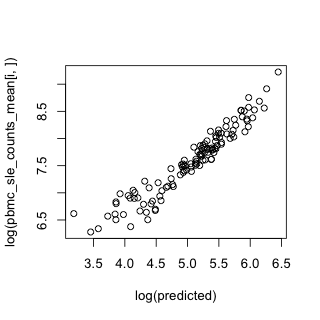

[1] 0.3085372

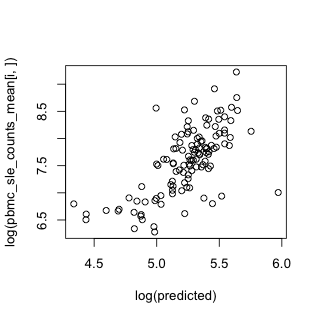

[1] 0.9686872

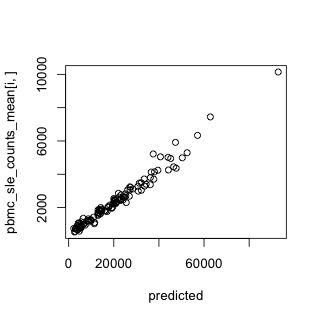

In [76]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=2
i=grep("^CD22$",expr_gene_names)[1]
predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
                               th_sle_counts_global_mean[i]*th_sle_prop/100,
                               b_sle_counts_global_mean[i]*b_sle_prop/100,
                               nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
                               ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
                               tc_sle_counts_global_mean[i]*tc_sle_prop/100,
                          dc_sle_counts_global_mean[i]*dc_sle_prop/100), na.rm=T)
plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
cor(predicted, pbmc_sle_counts_mean[i,])^2
output_sle_prop_noint[i,"adj r2"]

predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean, 
                              th_sle_counts_mean[i,]*th_sle_prop_global_mean, 
                              b_sle_counts_mean[i,]*b_sle_prop_global_mean,
                              nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
                               ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
                              tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
                          dc_sle_counts_mean[i,]*dc_sle_prop_global_mean), na.rm=T)

plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
cor(predicted, pbmc_sle_counts_mean[i,])^2

predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop, 
                              th_sle_counts_mean[i,]*th_sle_prop, 
                              b_sle_counts_mean[i,]*b_sle_prop,
                              nk_sle_counts_mean[i,]*nk_sle_prop, 
                               ncm_sle_counts_mean[i,]*ncm_sle_prop,
                              tc_sle_counts_mean[i,]*tc_sle_prop,
                          dc_sle_counts_mean[i,]*dc_sle_prop), na.rm=T)
plot(predicted, pbmc_sle_counts_mean[i,])
cor(predicted, pbmc_sle_counts_mean[i,])^2



### Now, let's downsample to 46 and redo SLE

In [77]:
cm_sle_down_counts_global_mean <- apply(exp(cm_sle_expr[,samples]),1,mean)
th_sle_down_counts_global_mean <- apply(exp(th_sle_expr[,samples]),1,mean)
tc_sle_down_counts_global_mean <- apply(exp(tc_sle_expr[,samples]),1,mean)
b_sle_down_counts_global_mean <- apply(exp(b_sle_expr[,samples]),1,mean)
nk_sle_down_counts_global_mean <- apply(exp(nk_sle_expr[,samples]),1,mean)
ncm_sle_down_counts_global_mean <- apply(exp(ncm_sle_expr[,samples]),1,mean)
dc_sle_down_counts_global_mean <- apply(exp(dc_sle_expr[,samples]),1,mean)

# cm_sle_down_counts_global_mean <- rowSums(exp(cm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples])
# th_sle_down_counts_global_mean <- rowSums(exp(th_sle_expr[,samples]))/sum((joined_pivot_sle$counts*th_sle_prop/100)[samples])
# tc_sle_down_counts_global_mean <- rowSums(exp(tc_sle_expr[,samples]))/sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples])
# b_sle_down_counts_global_mean <- rowSums(exp(b_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)
# nk_sle_down_counts_global_mean <- rowSums(exp(nk_sle_expr[,samples]))/sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples])
# ncm_sle_down_counts_global_mean <- rowSums(exp(ncm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples])
# dc_sle_down_counts_global_mean <- rowSums(exp(dc_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)

output_sle_down_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),samples])) {    
    predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop[samples]/100, 
                               th_sle_counts_global_mean[i]*th_sle_prop[samples]/100, 
                               b_sle_counts_global_mean[i]*b_sle_prop[samples]/100, 
                               nk_sle_counts_global_mean[i]*nk_sle_prop[samples]/100, 
                               ncm_sle_counts_global_mean[i]*ncm_sle_prop[samples]/100, 
                               tc_sle_counts_global_mean[i]*tc_sle_prop[samples]/100,##), na.rm=T)
                               dc_sle_counts_global_mean[i]*dc_sle_prop[samples]/100), na.rm=T)

    output_sle_down_direct_global_prop <- rbind(output_sle_down_direct_global_prop,
                                                c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
}


rownames(output_sle_down_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_sle_down_direct_global_prop) <- c("r2", "res")

output_sle_down_direct_global_expr <- NULL;

cm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
th_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*th_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
tc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
b_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)
nk_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
ncm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
dc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_sle_counts_mean[i,samples]*cm_sle_down_prop_global_mean,
                              th_sle_counts_mean[i,samples]*th_sle_down_prop_global_mean, 
                              b_sle_counts_mean[i,samples]*b_sle_down_prop_global_mean, 
                              nk_sle_counts_mean[i,samples]*nk_sle_down_prop_global_mean,
                              ncm_sle_counts_mean[i,samples]*ncm_sle_down_prop_global_mean, 
                              tc_sle_counts_mean[i,samples]*tc_sle_down_prop_global_mean,##), na.rm=T)
                              dc_sle_counts_mean[i,samples]*dc_sle_down_prop_global_mean), na.rm=T)

    output_sle_down_direct_global_expr <- rbind(output_sle_down_direct_global_expr, 
                                                c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
  
}


## Finally, processed the healthy

In [78]:
cm_healthy_counts_mean <- exp(cm_healthy_expr)
th_healthy_counts_mean <- exp(th_healthy_expr)
tc_healthy_counts_mean <- exp(tc_healthy_expr)
b_healthy_counts_mean <- exp(b_healthy_expr)
nk_healthy_counts_mean <- exp(nk_healthy_expr)
ncm_healthy_counts_mean <- exp(ncm_healthy_expr)
dc_healthy_counts_mean <- exp(dc_healthy_expr)
pbmc_healthy_counts_mean <- exp(pbmc_healthy_expr)


# cm_healthy_counts_mean <- sweep(exp(cm_healthy_expr), 2, joined_pivot_healthy$counts*cm_healthy_prop/100, "/")
# th_healthy_counts_mean <- sweep(exp(th_healthy_expr), 2, joined_pivot_healthy$counts*th_healthy_prop/100, "/")
# tc_healthy_counts_mean <- sweep(exp(tc_healthy_expr), 2, joined_pivot_healthy$counts*tc_healthy_prop/100, "/")
# b_healthy_counts_mean <- sweep(exp(b_healthy_expr), 2, joined_pivot_healthy$counts*b_healthy_prop/100, "/")
# nk_healthy_counts_mean <- sweep(exp(nk_healthy_expr), 2, joined_pivot_healthy$counts*nk_healthy_prop/100, "/")
# ncm_healthy_counts_mean <- sweep(exp(ncm_healthy_expr), 2, joined_pivot_healthy$counts*ncm_healthy_prop/100, "/")
# dc_healthy_counts_mean <- sweep(exp(dc_healthy_expr), 2, joined_pivot_healthy$counts*dc_healthy_prop/100, "/")
# pbmc_healthy_counts_mean <- sweep(exp(pbmc_healthy_expr), 2, joined_pivot_healthy$counts, "/")

cm_healthy_counts_global_mean <- apply(exp(cm_healthy_expr),1,mean)
th_healthy_counts_global_mean <- apply(exp(th_healthy_expr),1,mean)
tc_healthy_counts_global_mean <- apply(exp(tc_healthy_expr),1,mean)
b_healthy_counts_global_mean <- apply(exp(b_healthy_expr),1,mean)
nk_healthy_counts_global_mean <- apply(exp(nk_healthy_expr),1,mean)
ncm_healthy_counts_global_mean <- apply(exp(ncm_healthy_expr),1,mean)
dc_healthy_counts_global_mean <- apply(exp(dc_healthy_expr),1,mean)

# cm_healthy_counts_global_mean <- rowSums(exp(cm_healthy_expr))/sum(joined_pivot_healthy$counts*cm_healthy_prop/100, na.rm=T)
# th_healthy_counts_global_mean <- rowSums(exp(th_healthy_expr))/sum(joined_pivot_healthy$counts*th_healthy_prop/100, na.rm=T)
# tc_healthy_counts_global_mean <- rowSums(exp(tc_healthy_expr))/sum(joined_pivot_healthy$counts*tc_healthy_prop/100, na.rm=T)
# b_healthy_counts_global_mean <- rowSums(exp(b_healthy_expr))/sum(joined_pivot_healthy$counts*b_healthy_prop/100, na.rm=T)
# nk_healthy_counts_global_mean <- rowSums(exp(nk_healthy_expr))/sum(joined_pivot_healthy$counts*nk_healthy_prop/100, na.rm=T)
# ncm_healthy_counts_global_mean <- rowSums(exp(ncm_healthy_expr))/sum(joined_pivot_healthy$counts*ncm_healthy_prop/100, na.rm=T)
# dc_healthy_counts_global_mean <- rowSums(exp(dc_healthy_expr))/sum(joined_pivot_healthy$counts*dc_healthy_prop/100, na.rm=T)

##healthy_counts_means <- cbind(cm_healthy_counts_mean, th_healthy_counts_mean, tc_healthy_counts_mean, b_healthy_counts_mean, nk_healthy_counts_mean, ncm_healthy_counts_mean, dc_healthy_counts_mean)

output_healthy_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {    
    predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
                               th_healthy_counts_global_mean[i]*th_healthy_prop/100,
                               b_healthy_counts_global_mean[i]*b_healthy_prop/100,
                               nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
                               ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
                               tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,##), na.rm=T)
                               dc_healthy_counts_global_mean[i]*dc_healthy_prop/100),na.rm=T)

    output_healthy_direct_global_prop <- rbind(output_healthy_direct_global_prop, 
                                               c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
}


rownames(output_healthy_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_healthy_direct_global_prop) <- c("r2", "res")

output_healthy_direct_global_expr <- NULL;

cm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*cm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
th_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*th_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
tc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*tc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
b_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*b_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
nk_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*nk_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
ncm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*ncm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
dc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*dc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)

for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean,
                              th_healthy_counts_mean[i,]*th_healthy_prop_global_mean,
                              b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
                              nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
                               ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
                              tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,##), na.rm=T)
                              dc_healthy_counts_mean[i]*dc_healthy_prop_global_mean),na.rm=T)

   ##output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, c(var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100))
  output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, 
                                         c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
}

rownames(output_healthy_direct_global_expr) <- expr_gene_names;
colnames(output_healthy_direct_global_expr) <- c("r2", "res")

[1] 77.9196

[1] 77.49709

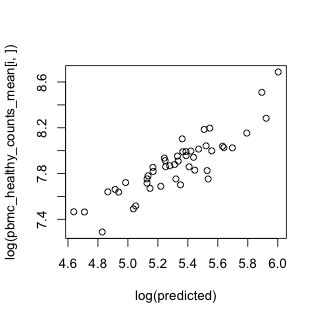

[1] 0.07358979

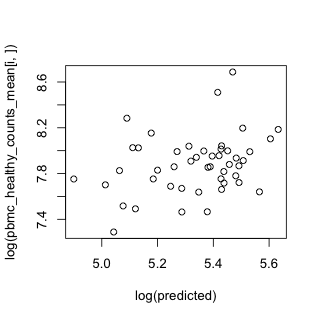

[1] 0.9331487

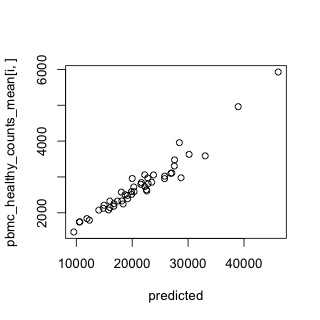

In [79]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=10
i=grep("^CD22$",expr_gene_names)[1]
predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
                               th_healthy_counts_global_mean[i]*th_healthy_prop/100,
                               b_healthy_counts_global_mean[i]*b_healthy_prop/100,
                               nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
                               ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
                               tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,
                          dc_healthy_counts_global_mean[i]*dc_healthy_prop/100), na.rm=T)
plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
cor(predicted, pbmc_healthy_counts_mean[i,])^2*100
output_healthy_prop_noint[i,"adj r2"]

predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean, 
                              th_healthy_counts_mean[i,]*th_healthy_prop_global_mean, 
                              b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
                              nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
                               ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
                              tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,
                          dc_healthy_counts_mean[i,]*dc_healthy_prop_global_mean), na.rm=T)
plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
cor(predicted, pbmc_healthy_counts_mean[i,])^2


predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop, 
                              th_healthy_counts_mean[i,]*th_healthy_prop, 
                              b_healthy_counts_mean[i,]*b_healthy_prop,
                              nk_healthy_counts_mean[i,]*nk_healthy_prop, 
                               ncm_healthy_counts_mean[i,]*ncm_healthy_prop,
                              tc_healthy_counts_mean[i,]*tc_healthy_prop,
                          dc_healthy_counts_mean[i,]*dc_healthy_prop), na.rm=T)
plot(predicted, pbmc_healthy_counts_mean[i,])
cor(predicted, pbmc_healthy_counts_mean[i,])^2

## Plotting

cor        prop_mean expr_mean sum_mean
all_noint      -0.7481077 25.86268  71.75159  97.61427
sle_noint      -0.7036715 27.83459  70.51765  98.35225
sle_down_noint -0.5500079 26.92723  71.91281  98.84003
healthy_noint  -0.6723116 17.41633  80.24335  97.65968

cM        Th        B        NK       ncM      Tc       
all_noint_prop       7.165910  4.083505 3.708530 1.935606 1.848803  2.093191
all_noint_expr      16.446523 11.403147 5.322387 3.033792 3.134284 10.474301
sle_noint_prop       7.133671  4.951707 4.213525 2.011148 2.064040  2.552130
sle_noint_expr      18.101796 10.190100 4.956862 2.838111 3.297087 10.070977
sle_down_noint_prop  7.033663  6.602571 5.302033 3.955714 3.111903  4.613604
sle_down_noint_expr 18.246164 11.344038 5.331273 3.367071 3.736953 11.633677
healthy_noint_prop   6.773521  3.073395 3.792244 3.962059 2.968014  2.198275
healthy_noint_expr  13.807900 17.610870 7.855162 4.713433 3.559177 13.487965
                    DC       total.r2 adj.r2  
all_noint_prop      1.710165 22.54571 25.86268
all_noint_expr      1.566752 51.38119 71.75159
sle_noint_prop      2.169362 25.09558 27.83459
sle_noint_expr      1.551193 51.00613 70.51765
sle_down_noint_prop 3.762695 34.38218 26.92723
sle_down_noint_expr 2.162417 55.82159 71.91281
healthy_noint_prop  2.712724 25.48023 17.41633
healthy_noint_expr  2.478187 63.51269 80.24335

Warning message:
“Removed 3 rows containing missing values (geom_point).”

Warning message:
“Removed 3 rows containing missing values (geom_point).”

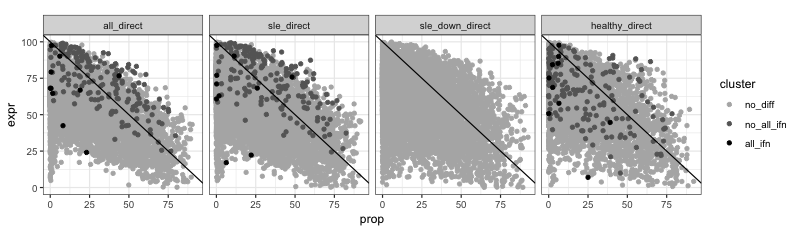

Warning message:
“Removed 3 rows containing missing values (geom_point).”

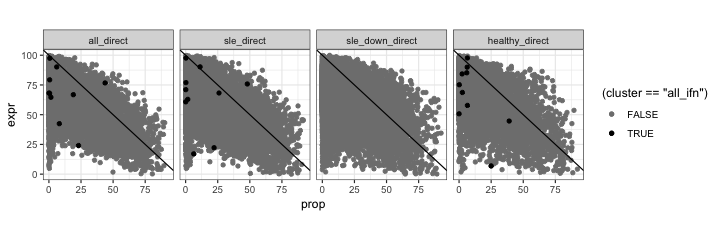

Warning message:
“Removed 3 rows containing missing values (geom_point).”

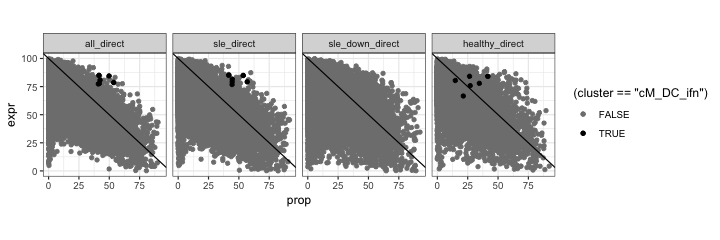

Warning message:
“Removed 3 rows containing missing values (geom_point).”

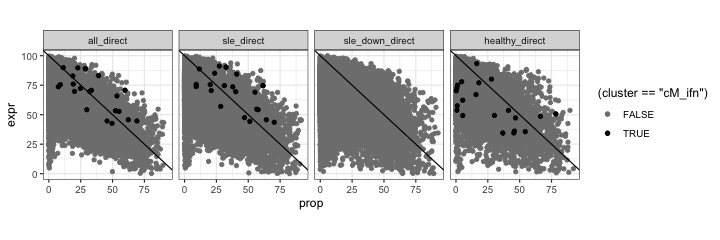

Warning message:
“Removed 3 rows containing missing values (geom_point).”

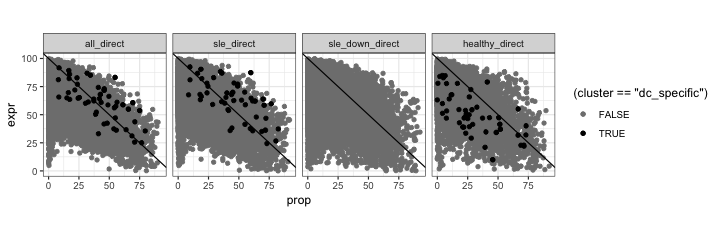

Warning message:
“Removed 3 rows containing missing values (geom_point).”

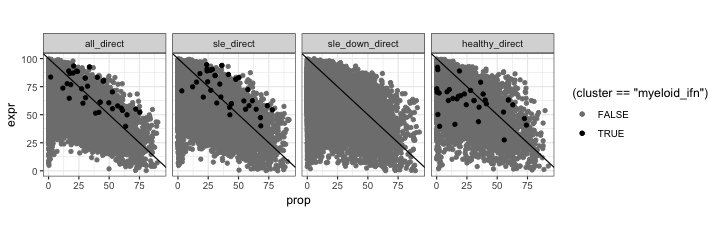

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

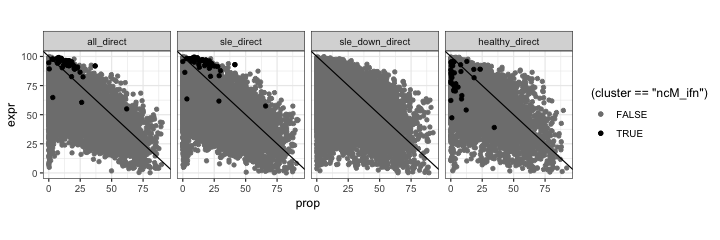

Warning message:
“Removed 3 rows containing missing values (geom_point).”

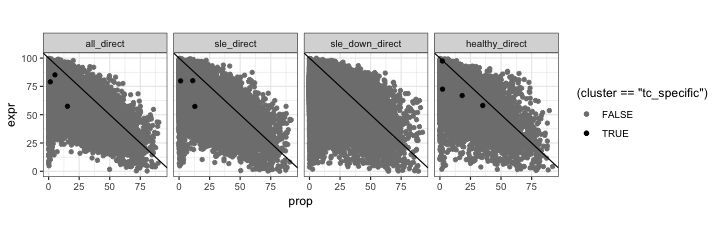

cor        prop_mean expr_mean sum_mean
all_direct      -0.6386328 16.18891  61.26083  77.44808
sle_direct      -0.6058391 17.71647  60.55166  78.26726
sle_down_direct -0.4678048 16.73857  62.08198  78.82054
healthy_direct  -0.5652230 12.48774  67.15210  79.63985

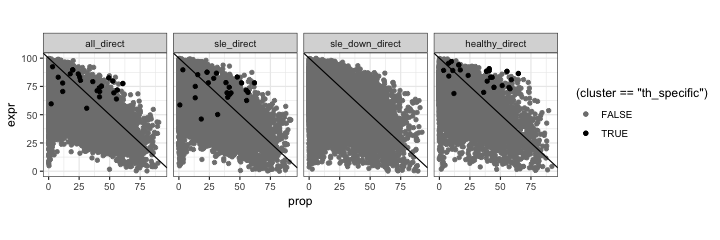

In [81]:
df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]), cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]), cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]), cor(output_healthy_prop_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])),
      prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"])),
      expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_expr_noint[,"adj r2"])),
      sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]+output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"]+output_healthy_expr_noint[,"adj r2"])))
rownames(df2) <- c("all_noint", "sle_noint", "sle_down_noint", "healthy_noint")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
             data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_expr_noint,2,mean,na.rm=T))))

rownames(df3) <- c("all_noint_prop", "all_noint_expr", "sle_noint_prop", "sle_noint_expr", "sle_down_noint_prop", "sle_down_noint_expr", "healthy_noint_prop", "healthy_noint_expr")

df3


output_direct_global_df <- data.frame(prop=output_direct_global_prop[,1], expr=output_direct_global_expr[,1], type="all_direct")
output_direct_global_df$cluster <- "no_diff";
output_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_direct_global_df)))] <- cuttree_out[,"cluster"];

output_sle_direct_global_df <- data.frame(prop=output_sle_direct_global_prop[,1], expr=output_sle_direct_global_expr[,1], type="sle_direct")
output_sle_direct_global_df$cluster <- "no_diff";
output_sle_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_direct_global_df)))] <- cuttree_out[,"cluster"];

output_sle_down_direct_global_df <- data.frame(prop=output_sle_down_direct_global_prop[,1], expr=output_sle_down_direct_global_expr[,1], type="sle_down_direct")
output_sle_down_direct_global_df$cluster <- "no_diff";
output_sle_down_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_down_direct_global_df)))] <- cuttree_out[,"cluster"];

output_healthy_direct_global_df <- data.frame(prop=output_healthy_direct_global_prop[,1], expr=output_healthy_direct_global_expr[,1], type="healthy_direct")
output_healthy_direct_global_df$cluster <- "no_diff";
output_healthy_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_healthy_direct_global_df)))] <- cuttree_out[,"cluster"];

df <- rbind(output_direct_global_df, output_sle_direct_global_df, output_sle_down_direct_global_df, output_healthy_direct_global_df)
df$cluster <- as.factor(df$cluster)


options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "all_ifn")] <- "no_all_ifn";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","no_all_ifn","all_ifn"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)


options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(aes(prop, expr,color=(cluster=="all_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'all_ifn'),
             aes(x = prop, y = expr, color = (cluster=="all_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="cM_DC_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_DC_ifn'),
             aes(x = prop, y = expr, color = (cluster=="cM_DC_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="cM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_ifn'),
             aes(x = prop, y = expr, color = (cluster=="cM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="dc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'dc_specific'),
             aes(x = prop, y = expr, color = (cluster=="dc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="myeloid_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'myeloid_ifn'),
             aes(x = prop, y = expr, color = (cluster=="myeloid_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="ncM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'ncM_ifn'),
             aes(x = prop, y = expr, color = (cluster=="ncM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="tc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'tc_specific'),
             aes(x = prop, y = expr, color = (cluster=="tc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="th_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'th_specific'),
             aes(x = prop, y = expr, color = (cluster=="th_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_direct_global_prop[,1], output_direct_global_expr[,1],use='complete.obs'), 
                        cor(output_sle_direct_global_prop[,1], output_sle_direct_global_expr[,1],use='complete.obs'), 
                        cor(output_sle_down_direct_global_prop[,1], output_sle_down_direct_global_expr[,1],use='complete.obs'),
                        cor(output_healthy_direct_global_prop[,1], output_healthy_direct_global_expr[,1])),
      prop_mean=c(mean(output_direct_global_prop[,1],na.rm=T), mean(output_sle_direct_global_prop[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1])),
      expr_mean=c(mean(output_direct_global_expr[,1]), mean(output_sle_direct_global_expr[,1]), mean(output_sle_down_direct_global_expr[,1]), mean(output_healthy_direct_global_expr[,1])),
      sum_mean = c(mean(output_direct_global_prop[,1]+output_direct_global_expr[,1],na.rm=T), mean(output_sle_direct_global_prop[,1]+output_sle_direct_global_expr[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1]+output_sle_down_direct_global_expr[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1]+output_healthy_direct_global_expr[,1])))
rownames(df2) <- c("all_direct", "sle_direct", "sle_down_direct", "healthy_direct")

df2


## Compare to previous estimates using linear regression

Warning message:
“Removed 4693 rows containing missing values (geom_point).”

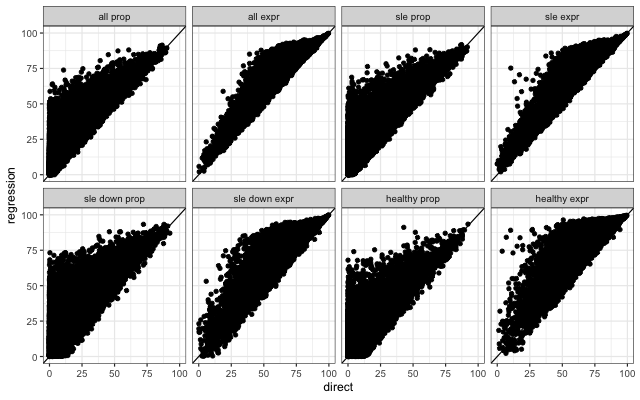

In [82]:
df <- rbind(data.frame(direct=output_direct_global_prop[,1], regression=output_prop_noint[,"adj r2"], type="all prop"),
            data.frame(direct=output_direct_global_expr[,1], regression=output_expr_noint[,"adj r2"], type="all expr"),
            
            data.frame(direct=output_sle_direct_global_prop[,1], regression=output_sle_prop_noint[,"adj r2"], type="sle prop"),
            data.frame(direct=output_sle_direct_global_expr[,1], regression=output_sle_expr_noint[,"adj r2"], type="sle expr"),
            
            data.frame(direct=output_sle_down_direct_global_prop[,1], regression=output_sle_down_prop_noint[,"adj r2"], type="sle down prop"),
            data.frame(direct=output_sle_down_direct_global_expr[,1], regression=output_sle_down_expr_noint[,"adj r2"], type="sle down expr"),
            
            data.frame(direct=output_healthy_direct_global_prop[,1], regression=output_healthy_prop_noint[,"adj r2"], type="healthy prop"),
            data.frame(direct=output_healthy_direct_global_expr[,1], regression=output_healthy_expr_noint[,"adj r2"], type="healthy expr"))
  
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+xlim(0,100)+ylim(0,100)+geom_abline(slope=1, intercept=0,
  na.rm = FALSE, show.legend = NA)
##ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+geom_abline(slope=1, intercept=0,
##  na.rm = FALSE, show.legend = NA)


In [83]:
cor(output_sle_direct_global_prop[,1], output_sle_prop_noint[,"adj r2"],use='complete.obs')
cor(output_sle_direct_global_expr[,1], output_sle_expr_noint[,"adj r2"])

cor(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"],use='complete.obs')
cor(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])

cor(output_healthy_direct_global_prop[,1], output_healthy_prop_noint[,"adj r2"])
cor(output_healthy_direct_global_expr[,1], output_healthy_expr_noint[,"adj r2"])

[1] 0.8726854

[1] 0.9230711

[1] 0.8114504

[1] 0.8806786

[1] 0.8010489

[1] 0.8499959

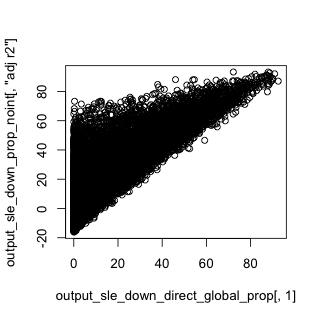

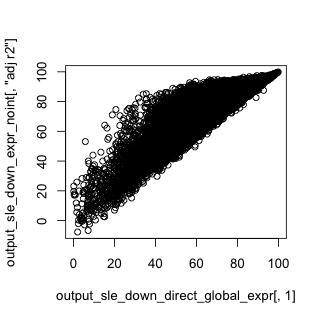

In [84]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"])
plot(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])


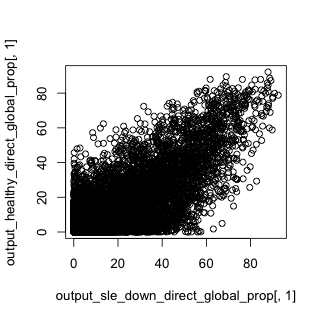

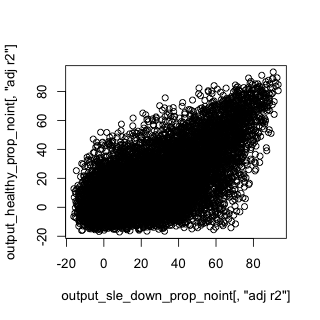

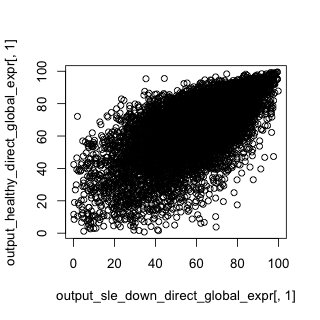

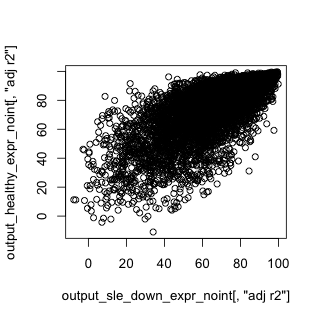

In [85]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_down_direct_global_prop[,1], output_healthy_direct_global_prop[,1])
plot(output_sle_down_prop_noint[,"adj r2"], output_healthy_prop_noint[,"adj r2"])
plot(output_sle_down_direct_global_expr[,1], output_healthy_direct_global_expr[,1])
plot(output_sle_down_expr_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])

# Load the cell type proportion estimates using the ```joined_pivot.txt``` generated by the Figure 1 code

In [86]:
# ifn = read.table("v2.ifn.sig.txt", sep=" ",header=T)
# ifn$name = sapply(ifn$name, function(x) {strsplit(as.character(x), "_")[[1]][[1]]})
# ifn

# match(colnames(pbmc_expr),joined_pivot$ind_cov)

# Correlate cell type specific expression with over all expression

No id variables; using all as measure variables
No id variables; using all as measure variables


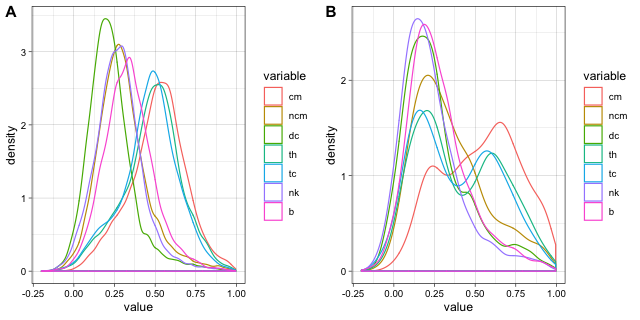

In [87]:
pbmc_cm_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],cm_expr[i,],use='complete.obs')})
pbmc_th_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],th_expr[i,],use='complete.obs')})
pbmc_b_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],b_expr[i,],use='complete.obs')})
pbmc_nk_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],nk_expr[i,],use='complete.obs')})
pbmc_ncm_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],ncm_expr[i,],use='complete.obs')})
pbmc_tc_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],tc_expr[i,],use='complete.obs')})
pbmc_dc_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],dc_expr[i,],use='complete.obs')})

mat_expr_cor <- data.frame(cm=pbmc_cm_expr_cor,
                           ncm=pbmc_ncm_expr_cor,
                             dc=pbmc_dc_expr_cor,
                           th=pbmc_th_expr_cor,
                           tc=pbmc_tc_expr_cor,
                          nk=pbmc_nk_expr_cor,
                          b=pbmc_b_expr_cor)
df_expr_cor <- melt(mat_expr_cor)
ggplot1 <- ggplot(aes(value,color=variable), data=df_expr_cor)+geom_density()+theme_linedraw();

mat_expr_cor_sig <- mat_expr_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_expr_cor_sig <- melt(mat_expr_cor_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_expr_cor_sig)+geom_density()+theme_linedraw();

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

## Let's plot the shifts in distribution for just the SLE samples

No id variables; using all as measure variables
No id variables; using all as measure variables


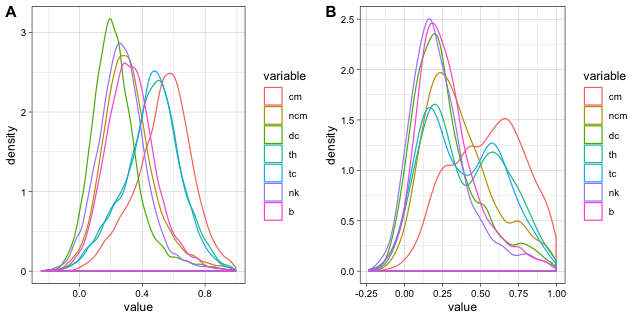

In [88]:
pbmc_cm_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],cm_sle_expr[i,],use='complete.obs')})
pbmc_th_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],th_sle_expr[i,],use='complete.obs')})
pbmc_b_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],b_sle_expr[i,],use='complete.obs')})
pbmc_nk_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],nk_sle_expr[i,],use='complete.obs')})
pbmc_ncm_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],ncm_sle_expr[i,],use='complete.obs')})
pbmc_tc_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],tc_sle_expr[i,],use='complete.obs')})
pbmc_dc_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],dc_sle_expr[i,],use='complete.obs')})

mat_sle_expr_cor <- data.frame(cm=pbmc_cm_sle_expr_cor,
                           ncm=pbmc_ncm_sle_expr_cor,
                             dc=pbmc_dc_sle_expr_cor,
                           th=pbmc_th_sle_expr_cor,
                           tc=pbmc_tc_sle_expr_cor,
                          nk=pbmc_nk_sle_expr_cor,
                          b=pbmc_b_sle_expr_cor)
df_sle_expr_cor <- melt(mat_sle_expr_cor)
ggplot1 <- ggplot(aes(value,color=variable), data=df_sle_expr_cor)+geom_density()+theme_linedraw();

mat_sle_expr_cor_sig <- mat_sle_expr_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_sle_expr_cor_sig <- melt(mat_sle_expr_cor_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_sle_expr_cor_sig)+geom_density()+theme_linedraw();

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

## Let's plot the shifts in distribution for just the healthy samples

No id variables; using all as measure variables
No id variables; using all as measure variables


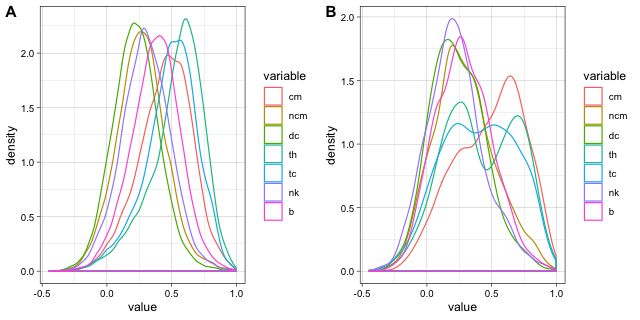

In [89]:
pbmc_cm_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],cm_healthy_expr[i,],use='complete.obs')})
pbmc_th_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],th_healthy_expr[i,],use='complete.obs')})
pbmc_b_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],b_healthy_expr[i,],use='complete.obs')})
pbmc_nk_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],nk_healthy_expr[i,],use='complete.obs')})
pbmc_ncm_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],ncm_healthy_expr[i,],use='complete.obs')})
pbmc_tc_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],tc_healthy_expr[i,],use='complete.obs')})
pbmc_dc_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],dc_healthy_expr[i,],use='complete.obs')})

mat_healthy_expr_cor <- data.frame(cm=pbmc_cm_healthy_expr_cor,
                           ncm=pbmc_ncm_healthy_expr_cor,
                             dc=pbmc_dc_healthy_expr_cor,
                           th=pbmc_th_healthy_expr_cor,
                           tc=pbmc_tc_healthy_expr_cor,
                          nk=pbmc_nk_healthy_expr_cor,
                          b=pbmc_b_healthy_expr_cor)
df_healthy_expr_cor <- melt(mat_healthy_expr_cor)
ggplot1 <- ggplot(aes(value,color=variable), data=df_healthy_expr_cor)+geom_density()+theme_linedraw();

mat_healthy_expr_cor_sig <- mat_healthy_expr_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_healthy_expr_cor_sig <- melt(mat_healthy_expr_cor_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_healthy_expr_cor_sig)+geom_density()+theme_linedraw();

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

# Let's look at contribution to total gene expression from each of the cell types

In [90]:
pbmc_cm_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(cm_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_ncm_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(ncm_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_th_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(th_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_tc_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(tc_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_nk_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(nk_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_b_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(b_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_dc_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(dc_counts[i,]/pbmc_counts[i,],na.rm=T)});

No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
“Removed 101751 rows containing non-finite values (stat_density).”Warning message:
“Removed 4865 rows containing non-finite values (stat_density).”

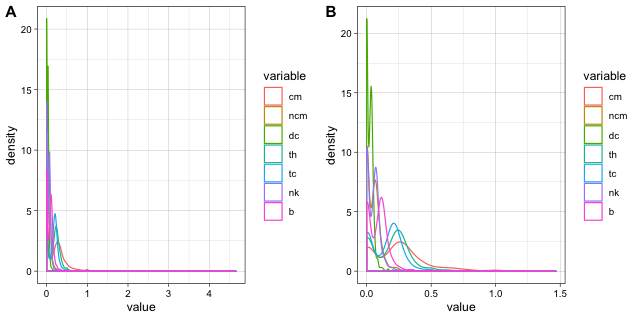

In [91]:
mat_counts_rat <- data.frame(cm=pbmc_cm_counts_rat,
                           ncm=pbmc_ncm_counts_rat,
                            dc=pbmc_dc_counts_rat,
                           th=pbmc_th_counts_rat,
                           tc=pbmc_tc_counts_rat,
                          nk=pbmc_nk_counts_rat,
                          b=pbmc_b_counts_rat)
df_counts_rat <- melt(mat_counts_rat)
ggplot1 <- ggplot(aes(value,color=variable), data=df_counts_rat)+geom_density()+theme_linedraw();

mat_counts_rat_sig <- mat_counts_rat[match(pbmc_deseq_sig,expr_gene_names),]
df_counts_rat_sig <- melt(mat_counts_rat_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_counts_rat_sig)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

# Correlate cell type proportion estimate with overall expression

No id variables; using all as measure variables
No id variables; using all as measure variables


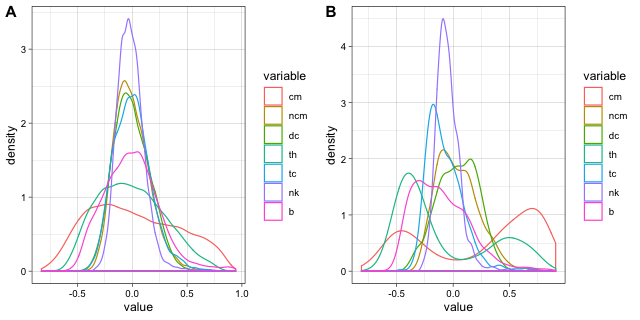

In [92]:
pbmc_cm_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],cm_prop,use='complete.obs')})
pbmc_th_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],th_prop,use='complete.obs')})
pbmc_b_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],b_prop,use='complete.obs')})
pbmc_nk_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],nk_prop,use='complete.obs')})
pbmc_ncm_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],ncm_prop,use='complete.obs')})
pbmc_tc_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],tc_prop,use='complete.obs')})
pbmc_dc_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],dc_prop,use='complete.obs')})

mat_prop_cor <- data.frame(cm=pbmc_cm_prop_cor,
                           ncm=pbmc_ncm_prop_cor,
                           dc=pbmc_dc_prop_cor,
                           th=pbmc_th_prop_cor,
                           tc=pbmc_tc_prop_cor,
                          nk=pbmc_nk_prop_cor,
                          b=pbmc_b_prop_cor)
df_prop_cor <- melt(mat_prop_cor)
ggplot1 = ggplot(aes(value,color=variable), data=df_prop_cor)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

mat_prop_cor_sig <- mat_prop_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_prop_cor_sig <- melt(mat_prop_cor_sig)
ggplot2 = ggplot(aes(value,color=variable), data=df_prop_cor_sig)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")


No id variables; using all as measure variables
No id variables; using all as measure variables


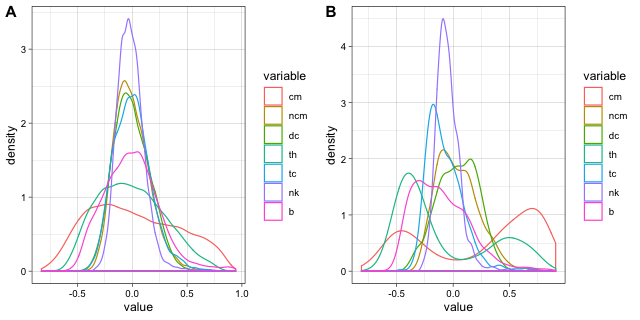

In [93]:
pbmc_std_expr <- t(apply(pbmc_expr,1,standardize));

pbmc_std_cm_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],cm_prop,use='complete.obs')})
pbmc_std_th_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],th_prop,use='complete.obs')})
pbmc_std_b_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],b_prop,use='complete.obs')})
pbmc_std_nk_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],nk_prop,use='complete.obs')})
pbmc_std_ncm_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],ncm_prop,use='complete.obs')})
pbmc_std_tc_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],tc_prop,use='complete.obs')})
pbmc_std_dc_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],dc_prop,use='complete.obs')})

mat_prop_cor <- data.frame(cm=pbmc_std_cm_prop_cor,
                           ncm=pbmc_std_ncm_prop_cor,
                           dc=pbmc_std_dc_prop_cor,
                           th=pbmc_std_th_prop_cor,
                           tc=pbmc_std_tc_prop_cor,
                          nk=pbmc_std_nk_prop_cor,
                          b=pbmc_std_b_prop_cor)
df_prop_cor <- melt(mat_prop_cor)
ggplot1 = ggplot(aes(value,color=variable), data=df_prop_cor)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

mat_prop_cor_sig <- mat_prop_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_prop_cor_sig <- melt(mat_prop_cor_sig)
ggplot2 = ggplot(aes(value,color=variable), data=df_prop_cor_sig)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")


## Some sanity checking code

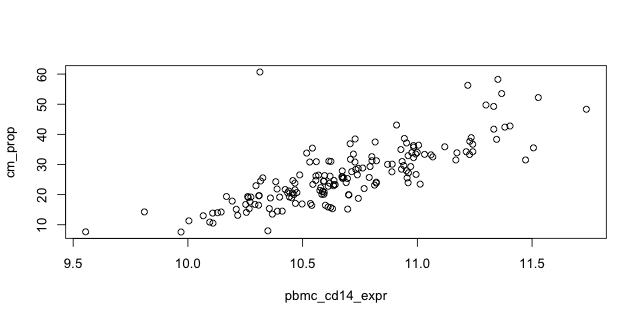

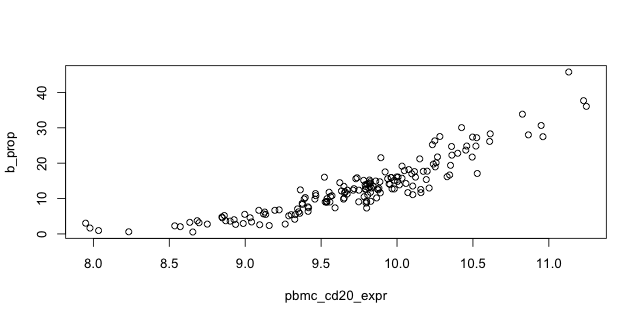

In [94]:
pbmc_cd14_expr = pbmc_expr[which(expr_gene_names=="CD14"),];
plot(pbmc_cd14_expr,cm_prop)

pbmc_cd20_expr = pbmc_expr[which(expr_gene_names=="MS4A1"),];
plot(pbmc_cd20_expr,b_prop)

In [95]:
cor(pbmc_cd14_expr, cm_prop, use='complete.obs')

[1] 0.7858541

In [96]:
counts <- fread("counts.txt",sep=",")
counts$V1 <- sapply(counts$V1, function(x) {strsplit(x,"_")[[1]][[1]]})
counts <- counts[match(colnames(pbmc_counts),counts$V1),]

In [97]:
pbmc_counts_norm <- as.matrix(sweep(pbmc_counts, 2, counts$V2, "/"))
pbmc_counts <- as.matrix(pbmc_counts) ##pbmc_counts_norm <- sapply(1:ncol(pbmc_counts), function(i) {pbmc_counts[,..i]/counts$V2[match(colnames(pbmc_counts)[i],counts$V1)]})

In [98]:
pbmc_cd14_counts <- pbmc_counts[which(counts_gene_names=="CD14"),match(joined_pivot_filtered$ind_cov,colnames(pbmc_counts))]
plot(log2(pbmc_cd14_counts), cm_prop)

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


In [ ]:
pbmc_cd14_counts_norm <- pbmc_counts_norm[which(counts_gene_names=="CD14"),match(joined_pivot_filtered$ind_cov,colnames(pbmc_counts))]
plot(log2(pbmc_cd14_counts_norm), cm_prop)

In [ ]:
cor(log2(pbmc_cd14_counts), cm_prop,use='complete')

In [ ]:
cor(log2(pbmc_cd14_counts_norm), cm_prop,use='complete')

In [ ]:
plot(pbmc_cm_prop_cor, pbmc_cm_expr_cor)

## Do a formal test for significance to expression and proportion

In [ ]:
pbmc_cm_expr_r2 <- sapply(1:nrow(pbmc_expr), function(i) {summary(lm(pbmc_expr[i,]~cm_expr[i,]))$r.squared})
pbmc_cm_expr_p <- sapply(1:nrow(pbmc_expr), function(i) {anova(lm(pbmc_expr[i,]~cm_expr[i,]))$"Pr(>F)"}[[1]])

In [ ]:
pbmc_cm_prop_r2 <- sapply(1:nrow(pbmc_expr), function(i) {summary(lm(pbmc_expr[i,]~cm_prop))$r.squared})
pbmc_cm_prop_p <- sapply(1:nrow(pbmc_expr), function(i) {anova(lm(pbmc_expr[i,]~cm_prop))$"Pr(>F)"}[[1]])

In [ ]:
pbmc_cm_expr_prop_r2 <- sapply(1:nrow(pbmc_expr), function(i) {summary(lm(pbmc_expr[i,]~cm_expr[i,]+cm_prop))$r.squared})
pbmc_cm_expr_prop_p <- sapply(1:nrow(pbmc_expr), function(i) {anova(lm(pbmc_expr[i,]~cm_expr[i,]+cm_prop))$"Pr(>F)"}[[1]])

In [ ]:
cm_expr_cm_prop_r2 <- sapply(1:nrow(cm_expr), function(i) {summary(lm(cm_expr[i,]~cm_prop))$r.squared})
cm_expr_cm_prop_p <- sapply(1:nrow(cm_expr), function(i) {anova(lm(cm_expr[i,]~cm_prop))$"Pr(>F)"}[[1]])

In [ ]:
plot(-log10(pbmc_cm_prop_p), -log10(pbmc_cm_expr_p))
pbmc_cm_prop_sig <- which(pbmc_cm_prop_p<1e-15)
pbmc_cm_expr_sig <- which(pbmc_cm_expr_p<1e-30)
#text(-log10(cd14_prop_p)[cd14_prop_sig], -log10(cd14_expr_p)[cd14_prop_sig], labels=gene_names[cd14_prop_sig], col="red")
#text(-log10(cd14_prop_p)[cd14_expr_sig], -log10(cd14_expr_p)[cd14_expr_sig], labels=gene_names[cd14_expr_sig], col="blue")

In [ ]:
pbmc_cm_total_r2 = pbmc_cm_prop_r2+pbmc_cm_expr_r2

In [ ]:
plot(pbmc_cm_prop_r2/pbmc_cm_expr_prop_r2, pbmc_cm_expr_prop_r2)

In [ ]:
# ## let's get the batch information
# covars <- fread("/ye/yelabstore2/10x.lupus/eqtls/v2/v2.covs.csv",header=T)
# covars <- covars[,c("ind", "well", "disease", "pop", "batch")]
# covars <- covars[!duplicated(covars$ind),]
# covars$ind[grep("1891",covars$ind)] <- "1891";
# covars$ind[grep("1221",covars$ind)] <- "1221";
# covars$ind[grep("1251",covars$ind)] <- "1251";

# ifn <- fread("v2.ifn.sig.txt");
# ifn$V1[grep("1891",ifn$V1)] <- "1891";
# ifn$V1[grep("1221",ifn$V1)] <- "1221";
# ifn$V1[grep("1251",ifn$V1)] <- "1251";


# ## get clinical data
# clinical = fread("/ye/yelabstore2/10x.lupus/clinical.data/v2/v2.clinical.data.txt",header=T,sep="\t")
# clinical$genotypeid[grep("1891",clinical$genotypeid)] <- "1891";
# clinical$genotypeid[grep("1221",clinical$genotypeid)] <- "1221";
# clinical$genotypeid[grep("1251",clinical$genotypeid)] <- "1251";

# cd14.rst <- pca_cell_type_plot("CD14+.Monocytes", covars, ifn, clinical)
# pbmc.rst <- pca_cell_type_plot("PBMC", covars, ifn, clinical)
# cd4.rst <- pca_cell_type_plot("CD4.T.cells", covars, ifn, clinical)
# cd19.rst <- pca_cell_type_plot("B.cells", covars, ifn, clinical)


# # healthy <- fread("v2.healthy.PBMC.expr.matrix.eqtl.txt")
# # sle <- fread("v2.PBMC.expr.matrix.eqtl.txt")

# # gene.names <- healthy$gene;

# # all <- cbind(healthy[,-1], sle[,-1]);

# # all.log <- log2(all);
# # sle.log <- log2(sle[,-1]);
# # all.log.norm <- apply(all.log, 2, function(x) {(x-mean(x))})
# # all.log.std <- t(apply(all.log.norm, 1, function(x) {(x-mean(x))/sd(x)}))

# # all.prcomp <- prcomp(all.log.std);

# # pdf("prcomp.pdf");
# # plot(all.prcomp$rotation[,c(1,2)]);
# # dev.off();

# # sle.prcomp <- prcomp(sle.log);

# # pdf("prcomp.sle.pdf");
# # plot(sle.prcomp$rotation[,c(1,2)]);
# # dev.off();

# # healthy.cd4 <- fread("v2.healthy.CD4.T.cells.expr.matrix.eqtl.txt")
# # sle.cd4 <- fread("v2.CD4.T.cells.expr.matrix.eqtl.txt")

# # all.cd4 <- cbind(healthy.cd4[,-1], sle.cd4[,-1])

# # all.cd4.log <- log2(all.cd4);
# # sle.cd4.log <- log2(sle.cd4[,-1]);

# # all.cd4.prcomp <- prcomp(all.cd4.log[-which(is.na(rowSums(all.cd4.log))),]);


# # pdf("cd4.prcomp.pdf");
# # plot(all.cd4.prcomp$rotation[,c(1,2)]);
# # dev.off();